# Imports and Data

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime as dt
import os
import matplotlib.pyplot as plt
import phonecalls as pc
import scipy.stats as stats
import scipy.interpolate as interpol
import statsmodels.api as sm
import pymannkendall as mk
import time
import copy
import math
import pickle


plt.rcParams['figure.figsize'] = (20, 10)
markers = ['o', 'v', 's', 'P', '*', 'X', 'd', 'x', 'D', '2', '+']
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']


unfiltered = pd.read_pickle('unfiltered.pkl')


# with open('../itdata/mtl_unfiltered.pickle', 'rb') as handle:
#     tmpunf = pickle.load(handle)
#     handle.close()

tmpunf = pd.read_pickle('../itdata/mtl_unfiltered.pickle')
unfiltered.update(tmpunf)

# with open('../itdata/mtl_dffa15.pickle', 'rb') as handle:
#     itdffa15 = pickle.load(handle)
#     handle.close()
itdffa15 = pd.read_pickle('../itdata/mtl_dffa15.pickle')
# with open('../itdata/mtl_dffa30.pickle', 'rb') as handle:
#     itdffa30 = pickle.load(handle)
#     handle.close()
itdffa15 = pd.read_pickle('../itdata/mtl_dffa30.pickle')
# with open('../itdata/mtl_livesd.pickle', 'rb') as handle:
#     itlives = pickle.load(handle)
#     handle.close()
itlives = pd.read_pickle('../itdata/mtl_livesd.pickle')
# unfiltered['mit'] = pc.allcalls('../usadata/CallLog.csv', ('type', 'outgoing', 'outgoing+', 'missed'), 'participantID.A', 'number.hash', 
#                                 ['local_time'], "%Y-%m-%d %H:%M:%S", header=True, min_activity=1)
unfiltered['mit'] = pd.read_csv("data/USc.txt", sep="\t", parse_dates=[3, 4]).rename({'a': 'aclock', 't': 'uclock'}, axis='columns')
# unfiltered['uk12'] = pd.DataFrame()
# for c in ['uk1', 'uk2']:
#     df = unfiltered[c].copy(deep=True)
#     df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
#     unfiltered['uk12'] = unfiltered['uk12'].append(df)
unfiltered['uk12'] = pd.DataFrame()  # Ensure this is an empty DataFrame
for c in ['uk1', 'uk2']:
    df = unfiltered[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    unfiltered['uk12'] = pd.concat([unfiltered['uk12'], df], ignore_index=True)


L = {'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}
calls = {}
for c in ['uk', 'uk1', 'uk2', 'it', 'mit']:
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    calls[c] = pc.apply_filters(df, 60)
# calls['uk12'] = pd.DataFrame()
# for c in ['uk1', 'uk2']:
#     df = calls[c].copy(deep=True)
#     df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
#     calls['uk12'] = calls['uk12'].append(df)
calls['uk12'] = pd.DataFrame()  # Start with an empty DataFrame
for c in ['uk1', 'uk2']:
    df = calls[c].copy(deep=True)
    df['ego'] = df['ego'].map(lambda i: f'{dict({"uk1": "a", "uk2": "b"})[c]}{i}')
    calls['uk12'] = pd.concat([calls['uk12'], df], ignore_index=True)
globalt0 = dt.datetime.now()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/5z/l623l2s516gg11xk465j65mw0000gn/T/ipykernel_36529/598663370.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  unfiltered['mit'] = pd.read_csv("data/USc.txt", sep="\t", parse_dates=[3, 4]).rename({'a': 'aclock', 't': 'uclock'}, axis='columns')


In [10]:
for c in ['uk2', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['pair'].unique()))

uk2 920
it 4052
mit 2653


In [11]:
for c in ['uk', 'uk2', 'it', 'mit']:
    print(c, min(unfiltered[c]['time']), max(unfiltered[c]['time']), max(unfiltered[c]['uclock']) - min(unfiltered[c]['uclock']))

uk 2007-03-05 13:17:00 2008-08-31 20:13:00 545
uk2 2007-09-01 15:05:00 2008-08-31 20:13:00 365
it 2013-02-01 08:03:16 2014-12-31 23:46:21 698
mit 2010-02-27 15:37:07 2011-07-16 19:55:04 504


# Fig 1 with resampling
The resampling is all about making all cohorts comparable.

In [12]:
for c in ['it', 'mit']:
    # No Filter
    df = unfiltered[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['ea'].unique()))
    # L
    lf = df.groupby('ea')[['aclock']].max()
    keep = lf.loc[lf['aclock'] <= L[c]]
    df = df[df['ea'].isin(keep.index)]
    print(c, len(df['ea'].unique()))
    # ncalls = df.groupby('ea')[['time']].count()
    # keep = ncalls.loc[ncalls['time'] >= 3]
    # df = df[df['ea'].isin(keep.index)]
    # calls[{'it': 'itL', 'mit': 'mitL'}[c]] = df
    # print(c, len(df['ea'].unique()))
    # Delta t to the left (by ego)
    t0i = df.groupby('ego')['uclock'].min()
    print(t0i[24])
    t0x = df.groupby('ea')[['uclock']].min()
    t0x['dif'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
    keep = t0x.loc[t0x['dif'] > 50]
    df = df[df['ea'].isin(keep.index)]
    print(len(df['ea'].unique()))
    # Delta t to the right
    df = pc.apply_filters(df, 60)
    df['ea'] = list(zip(df['ego'], df['alter']))
    print(len(df['ea'].unique()))
    calls[{'it': 'itb', 'mit': 'mitb'}[c]] = df

it 23674
it 21064
4
17501
2736
mit 10860
mit 10263
225
7474
1542


/var/folders/5z/l623l2s516gg11xk465j65mw0000gn/T/ipykernel_36529/187825032.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(t0i[24])


In [13]:
tmp = calls['itb'].copy(deep=True)
tmp['ea'] = list(zip(tmp['ego'], tmp['alter']))
t0i = tmp.groupby('ego')['uclock'].min()
t0x = tmp.groupby('ea')[['uclock']].min()
t0x['t0'] = t0x.index.map(lambda i: t0x.at[i, 'uclock'] - t0i[i[0]])
tmp2 = t0x.loc[t0x['t0'] > 50]
df = tmp[tmp['ea'].isin(tmp2.index)]

In [14]:
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    print(c, len(df['pair'].unique()))

uk2 920
itb 2736
it 4052
mit 2653


## Detour: alter lifetime

In [31]:
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    mindf = df.groupby('pair')[['uclock']].min()
    maxdf = df.groupby('pair')[['uclock']].max()
    lft = mindf.merge(maxdf, how='outer', left_index=True, right_index=True)
    lft.columns = ['t0', 'tf']
    lft['lft'] = lft['tf'] - lft['t0'] + 1
    lft.reset_index(inplace=True, drop=True)
    lft.to_csv(f'toAlan/{c}.txt', sep="\t", index=False, header=True)

## End of detour

In [7]:
limits = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    limits[c] = []
    limits[c].append((0, 50))
    limits[c].append((L[c] // 2 - 25, L[c]//2 + 25))
    limits[c].append((L[c] - 50, L[c]))
limits

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (157, 207), (315, 365)],
 'it': [(0, 50), (157, 207), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [8]:
limits2 = {}
for c in limits.keys():
    if c not in ['itb', 'it']:
        limits2[c] = limits[c]
    else:
        limits2[c] = [(0, 50), (180, 230), (315, 365)]

In [9]:
t0 = dt.datetime.now()
fig1 = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    fig1[c] = {}
    for i in range(3):
        fig1[c][i] = pc.get_fal(calls[c], limits[c][i][0], limits[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:02.674823


In [10]:
dashed = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    dashed[c] = {}
    print(f'======================={c}=====================')
    for lamb in fig1[c].keys():
        if lamb >= 0:
            points = pc.get_b_slopes(fig1[c][lamb]['f'])
            print(pc.get_b_mk(fig1[c][lamb]['f']))
            dashed[c][lamb] = points
            print(f'\draw[dashed, {["charmander", "squirtle", "ekans"][lamb]}, ultra thick] (axis cs: {points[0][0]}, {points[1][0]}) -- (axis cs: {points[0][1]}, {points[1][1]});')

=======================uk2=====================
[[1, 2], [0.663175464631242, 0.663175464631242], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.663175464631242) -- (axis cs: 2, 0.663175464631242);
[[1, 9], [1.87373430853823, 1.87373430853823], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 1.87373430853823) -- (axis cs: 9, 1.87373430853823);
[[1, 16], [2.4968990752451297, 2.4968990752451297], 999]
\draw[dashed, ekans, ultra thick] (axis cs: 3, 2.448535988086695) -- (axis cs: 13, 2.448535988086695);
=======================itb=====================
[[1, 2], [0.5495548728469455, 0.5495548728469455], 999]
\draw[dashed, charmander, ultra thick] (axis cs: 1, 0.5495548728469455) -- (axis cs: 2, 0.5495548728469455);
[[1, 12], [0.8390481094780258, 0.8390481094780258], 999]
\draw[dashed, squirtle, ultra thick] (axis cs: 1, 0.8390481094780258) -- (axis cs: 12, 0.8390481094780258);
[[1, 23], [1.8565024008234312, 1.8565024008234312], 999]
\draw[dashed, ekans, ultra thick] (axis c

In [11]:
dashed['mit'][1]

[[4, 5], [1.754115587695133, 1.754115587695133]]

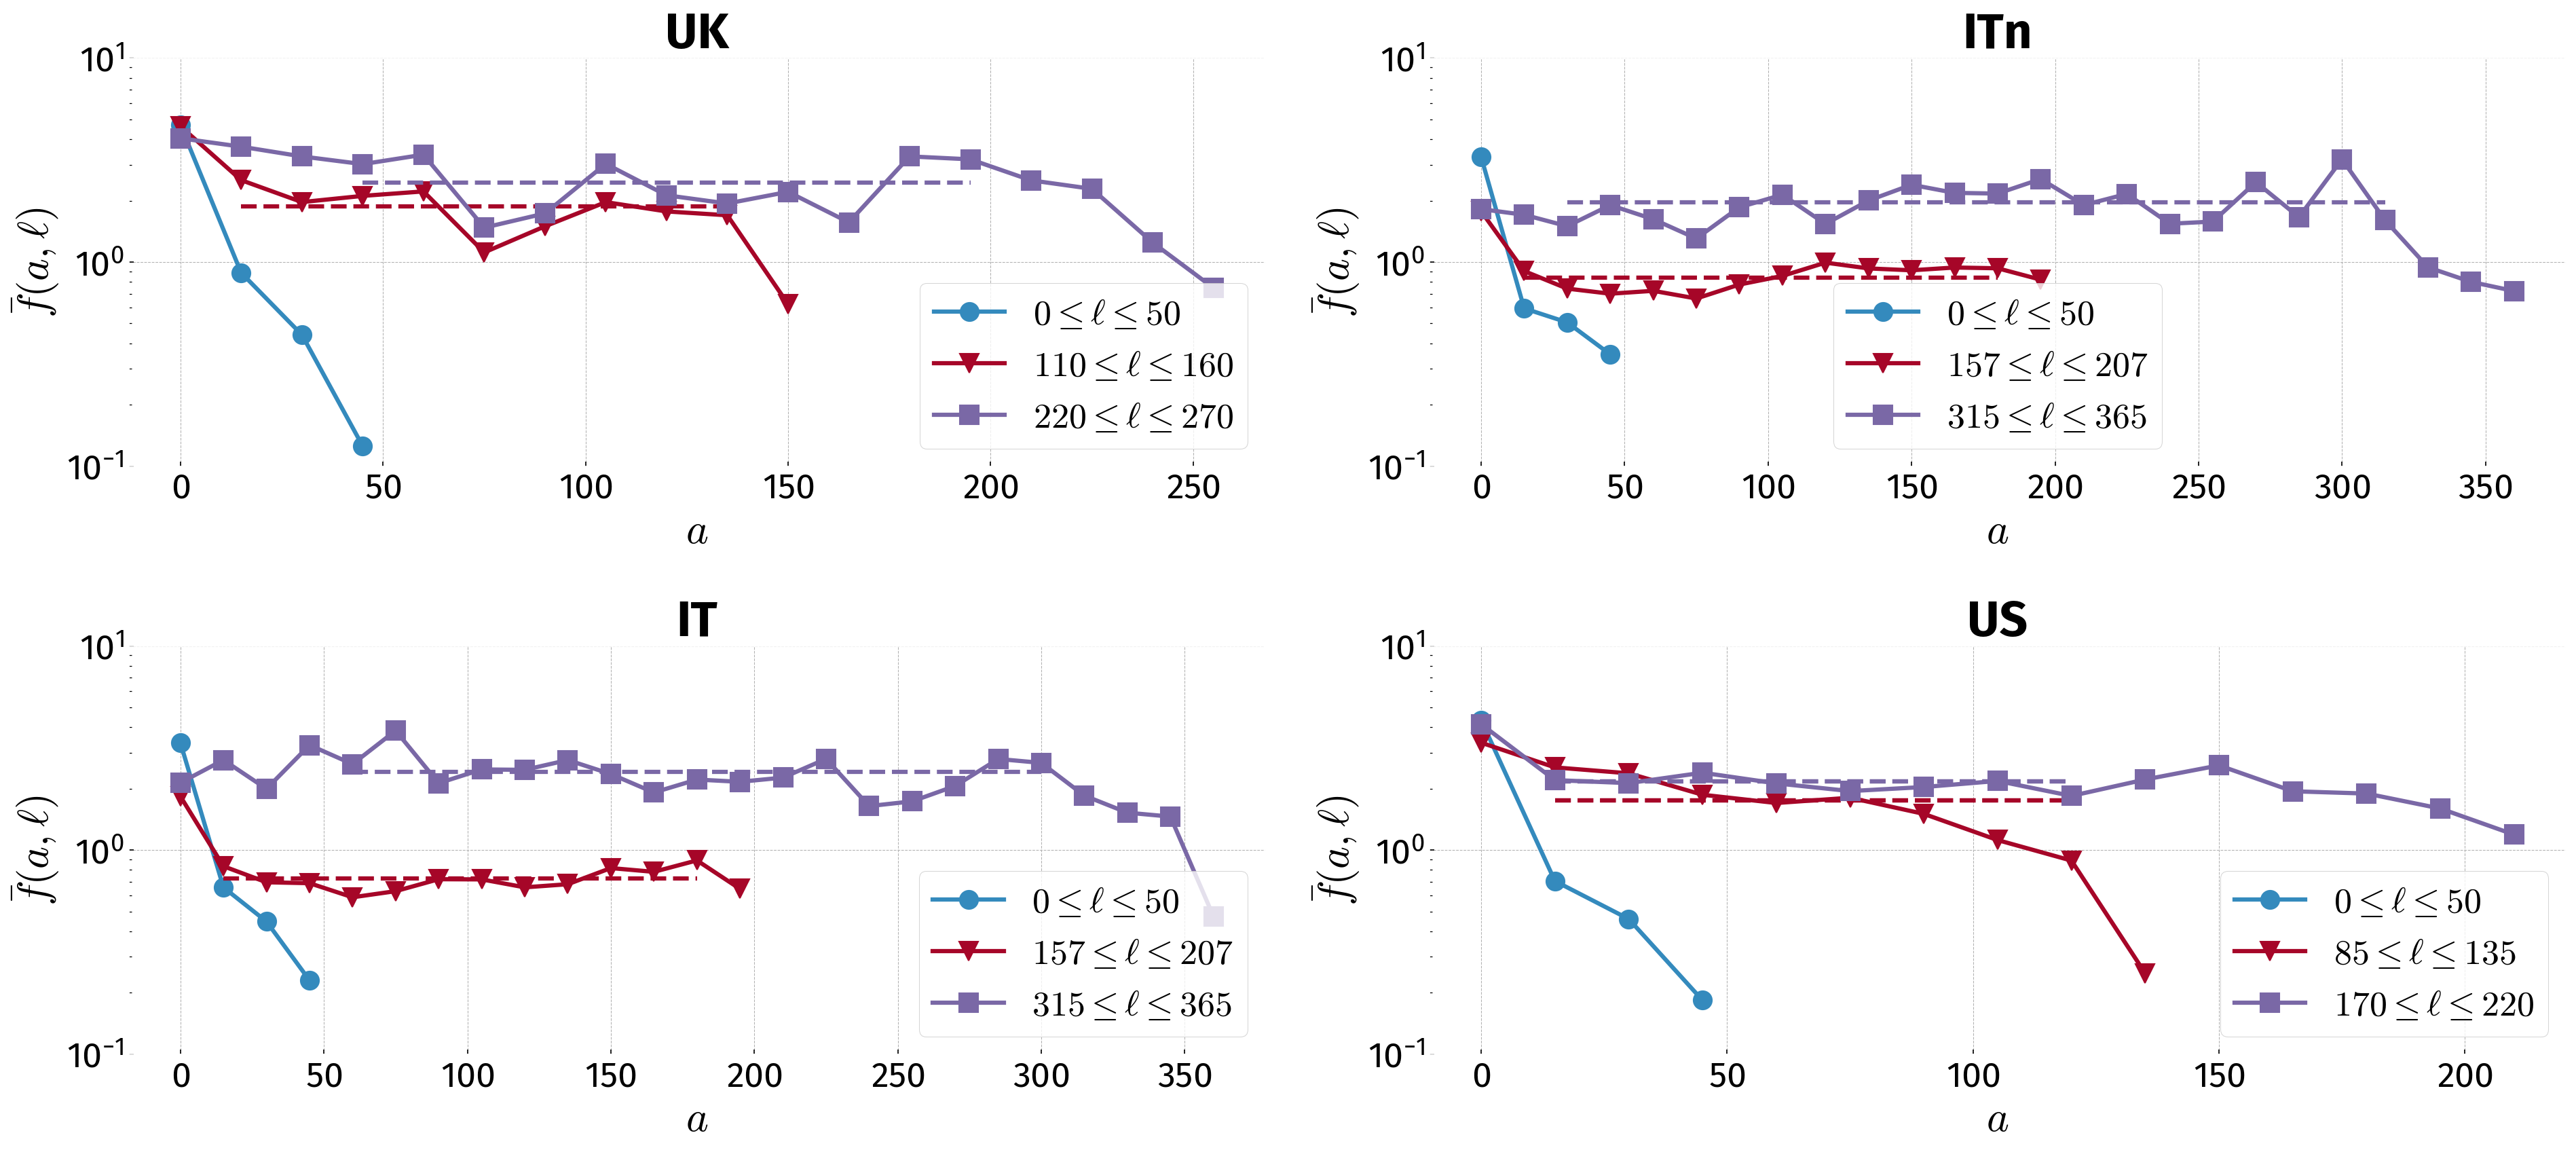

In [12]:
country_labels = {'uk2': 'UK', 'itb': 'ITn', 'it': 'IT', 'mit': 'US'}
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in ['uk2', 'itb', 'it', 'mit']:
    plt.subplot(nr, nc, p)
    plt.title(f"{country_labels[c]}")
    plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    plt.xlabel(fr'$a$')
    plt.ylabel(r'$\bar{f}(a, \ell)$')
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index * 15, fig1[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits[c][i][0]}\leq \ell \leq {limits[c][i][1]}$')
        if (i > 0) and (c != 'mit'):
            plt.plot([x * 15 for x in dashed[c][i][0]], dashed[c][i][1], marker="", ls="--", lw=3, c=colors[i])
        elif (i > 0) and (c == 'mit'):
            plt.plot([x * 15 for x in range(1,9)], [dashed[c][i][1] for _ in range(1,9)], marker="", ls="--", lw=3, c=colors[i])
    plt.legend()
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/fig1.pdf", dpi=200)

# Number of alive egos (in fig1)

In [13]:
t0 = dt.datetime.now()
fig1ale = {}
for c in fig1.keys():
    fig1ale[c] = {}
    df = calls[c].copy(deep=True)
    df['pair'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('pair')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    for i in range(1,3):
        result = pd.DataFrame()
        lf1 = lf.loc[(lf['ell'] >= limits[c][i][0]) & (lf['ell'] <= limits[c][i][1])]
        df1 = df[df['pair'].isin(lf1.index)]
        mina = limits[c][i][0]
        maxa = limits[c][i][1]
        for a in range(mina, maxa + 1):
            lf2 = lf1.loc[lf1['ell'] >= a]
            df2 = df1[df1['pair'].isin(lf2.index)]
            result.at[a, 'ale'] = len(df2['ego'].unique())
        fig1ale[c][i] = result.copy()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.491874


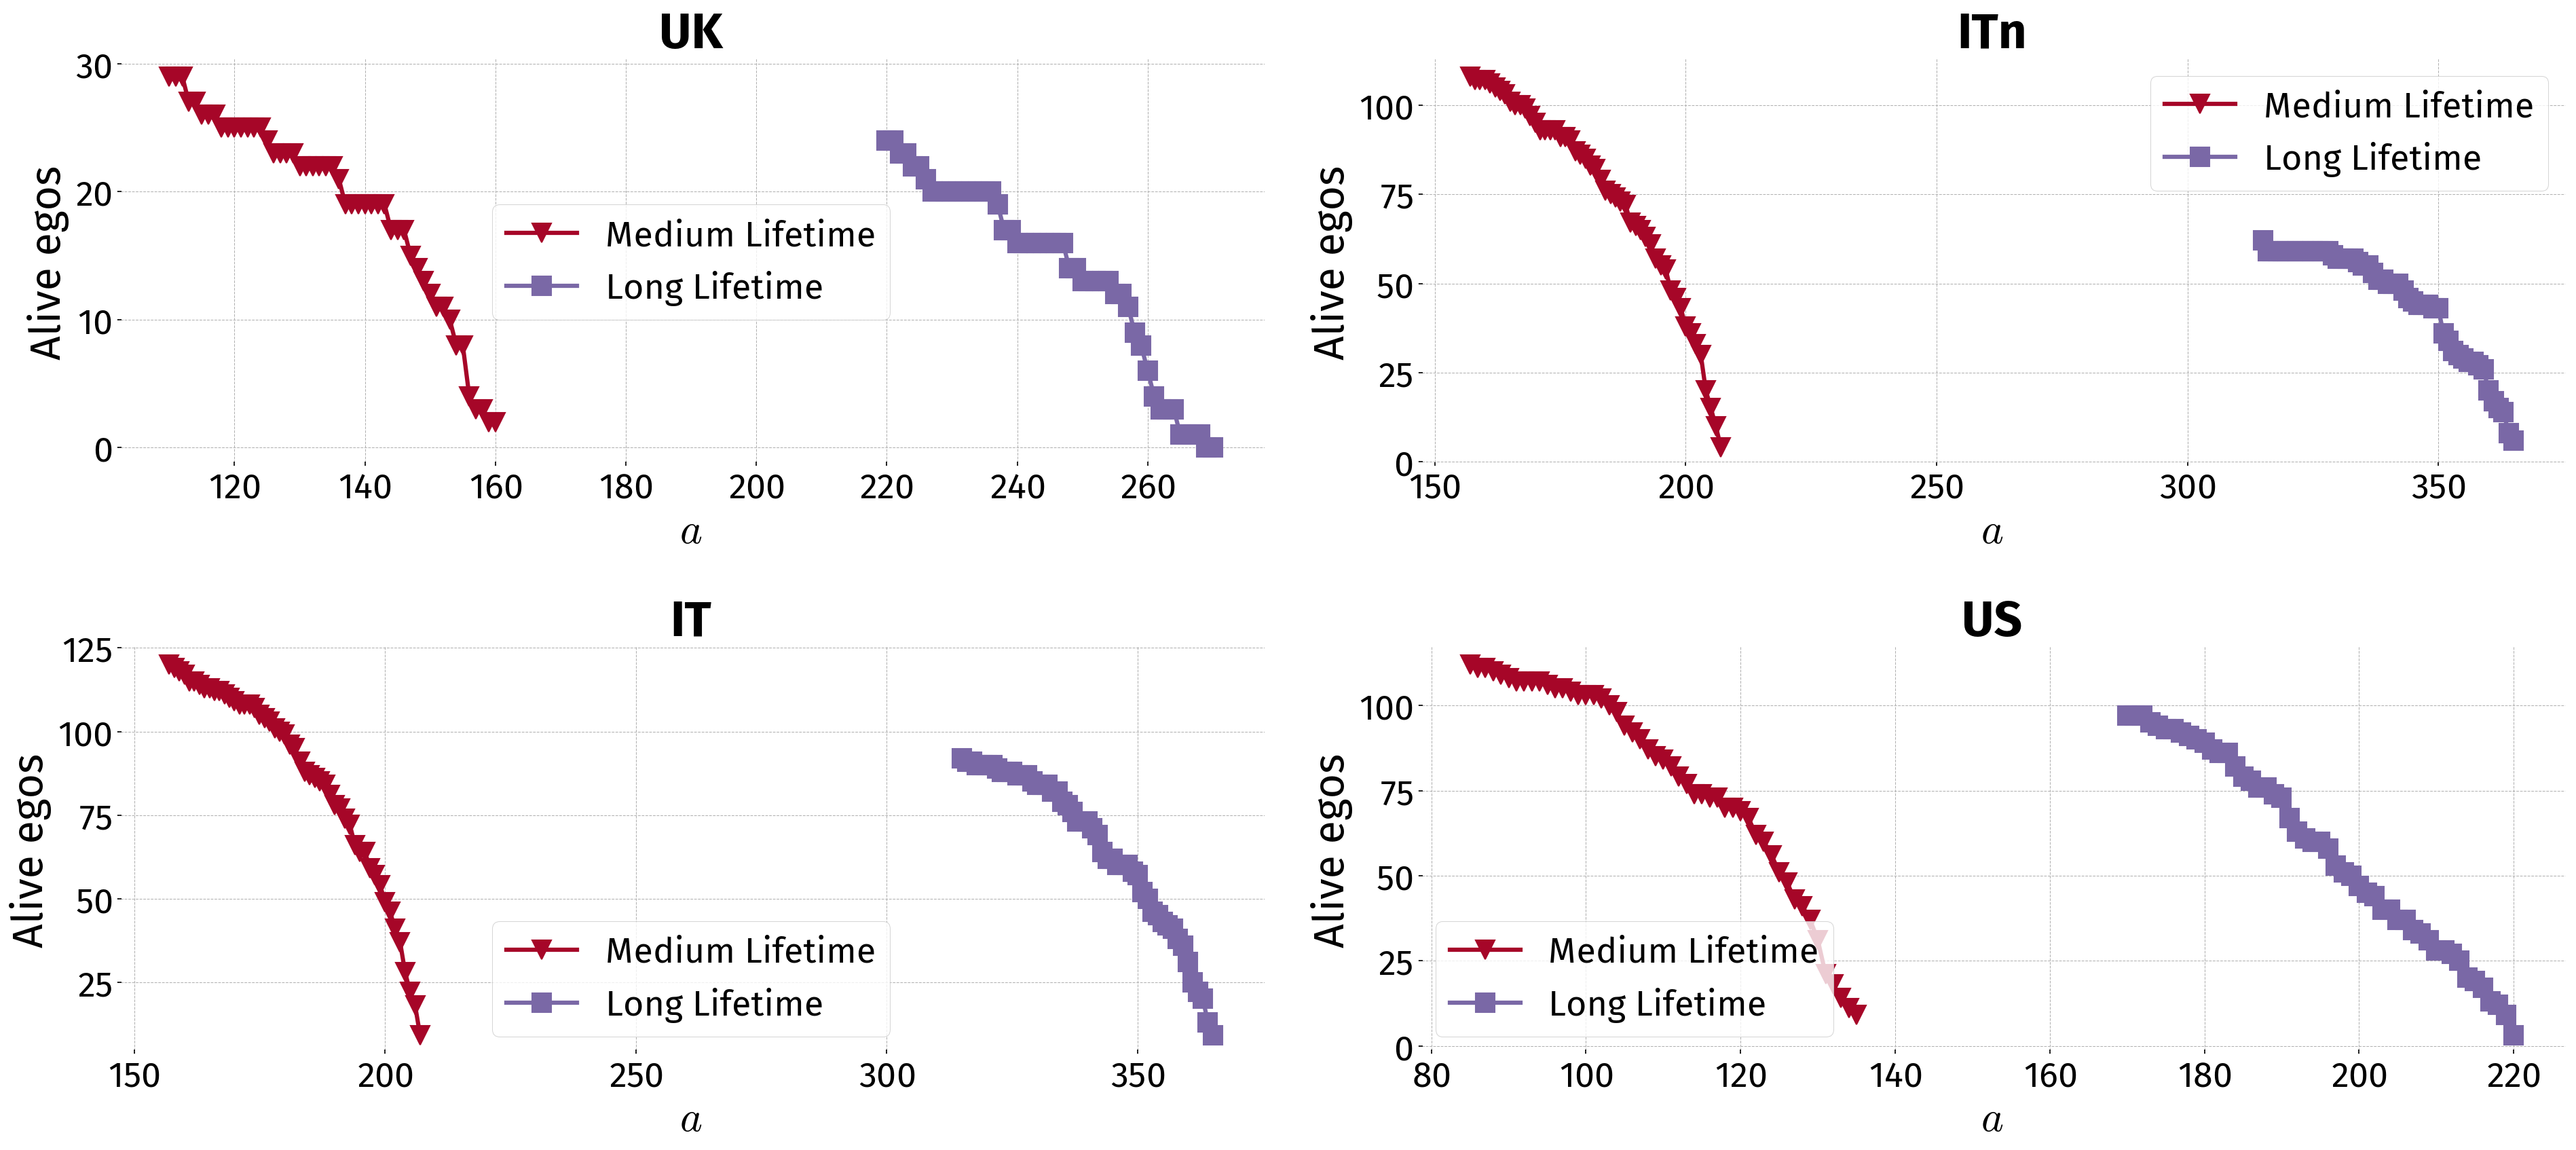

In [14]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1ale.keys():
    plt.subplot(nr, nc, p)
    plt.title(country_labels[c])
    plt.xlabel("$a$")
    plt.ylabel("Alive egos")
    for i in range(1,3):
        plt.plot(fig1ale[c][i].index, fig1ale[c][i]['ale'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['BHBH', 'Medium Lifetime', 'Long Lifetime'][i])
    plt.legend()
    plt.tight_layout()
    p += 1

In [15]:
a = fig1ale['uk2'][2].copy().rename({'ale': 'Y1uk2'}, axis='columns')
a['X1uk2'] = a.index
a

Y1uk2  X1uk2
220   24.0    220
221   24.0    221
222   23.0    222
223   23.0    223
224   22.0    224
225   22.0    225
226   21.0    226
227   20.0    227
228   20.0    228
229   20.0    229
230   20.0    230
231   20.0    231
232   20.0    232
233   20.0    233
234   20.0    234
235   20.0    235
236   20.0    236
237   19.0    237
238   17.0    238
239   17.0    239
240   16.0    240
241   16.0    241
242   16.0    242
243   16.0    243
244   16.0    244
245   16.0    245
246   16.0    246
247   16.0    247
248   14.0    248
249   14.0    249
250   13.0    250
251   13.0    251
252   13.0    252
253   13.0    253
254   13.0    254
255   12.0    255
256   12.0    256
257   11.0    257
258    9.0    258
259    8.0    259
260    6.0    260
261    4.0    261
262    3.0    262
263    3.0    263
264    3.0    264
265    1.0    265
266    1.0    266
267    1.0    267
268    1.0    268
269    0.0    269
270    0.0    270

In [16]:
tmp = pd.DataFrame()
for c in fig1ale.keys():
    for l in fig1ale[c].keys():
        df = fig1ale[c][l].copy().rename({'ale': f'Y{l}{c}'}, axis='columns')
        df[f'X{l}{c}'] = df.index
        df = df.reset_index(drop=True)
        tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.fillna('nan', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/aliveegos.dat", header=True, index=False, sep="\t")

# $\bar{f}(a, \ell > \ell_s)$

In [17]:
ells = {'uk2': 51.13, 'itb': 66.14, 'it': 56.49, 'mit': 56.51}

In [18]:
t0 = dt.datetime.now()
fauniv= {}
for c in ['uk2', 'itb', 'it', 'mit']:
    fauniv[c] = {}
    df0 = calls[c].copy(deep=True)
    df0['pair'] = list(zip(df0['ego'], df0['alter']))
    lf = df0.groupby('pair')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    fauniv[c] = {'fi': {}}
    lf1 = lf.loc[(lf['ell'] >= ells[c])]
    df1 = df0[df0['pair'].isin(lf1.index)]
    for ego in df1['ego'].unique():
        df2 = df1.loc[df1['ego'] == ego]
        bya = df2.groupby('aclock')[['time']].count().rename({'time': 'fi'}, axis='columns').sort_index()
        bya['fi'] /= len(df2['alter'].unique())
        fauniv[c]['fi'][ego] = bya.copy()
    df3 = pd.DataFrame()
    for ego in fauniv[c]['fi'].keys():
        df3 = df3.merge(fauniv[c]['fi'][ego].rename({'fi': f'fi{ego}'}, axis='columns'), left_index=True, right_index=True, how='outer')
    df3['f'] = df3.mean(axis=1)
    fauniv[c]['f'] = df3[['f']]
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:01.639098


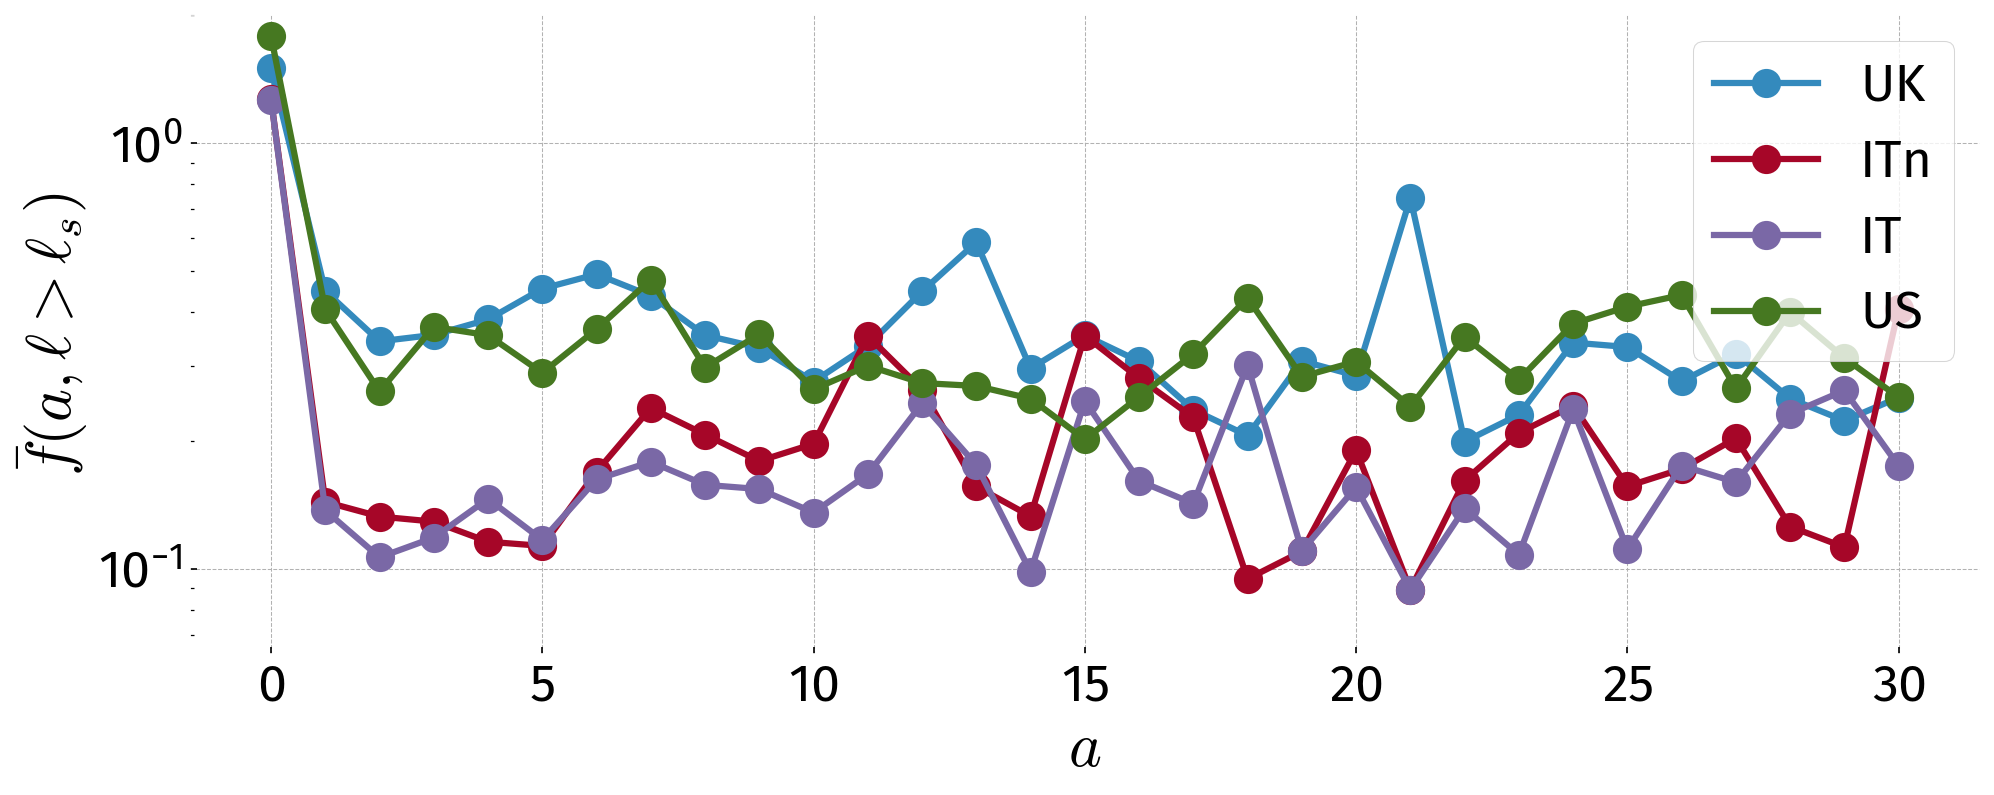

In [19]:
plt.figure(figsize=(14,6))
plt.xlabel("$a$")
plt.ylabel(r"$\bar{f}(a, \ell > \ell_s)$")
plt.semilogy()
plt.ylim(10**(-1.2), 2)
for c in fauniv.keys():
    df = fauniv[c]['f'].loc[fauniv[c]['f'].index <= 30]
    plt.plot(df.index, df['f'], marker="o", markersize=13, ls="solid", lw=3, label=country_labels[c])
plt.legend()
plt.tight_layout()

In [20]:
tmp = pd.DataFrame()
for c in fauniv.keys():
    df = fauniv[c]['f'].loc[fauniv[c]['f'].index <= 30].rename({'f': c}, axis='columns')
    tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
tmp.index.rename('a', inplace=True)
tmp.fillna('nan', inplace=True)
# tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/faells.dat", header=True, sep="\t")

# Confidence Intervals for $f(a, \ell)$

## Using a $T$ distribution

In [21]:
from scipy.stats import t as tst
t0 = dt.datetime.now()
fig1cit = {}
for c in fig1.keys():
    fig1cit[c] = {}
    for l in fig1[c].keys():
        fig1cit[c][l] = pd.DataFrame()
        dict1 = {}
        for idx in fig1[c][l]['f'].index:
            dict1[idx] = []
            for ego in fig1[c][l]['fi'].keys():
                df = fig1[c][l]['fi'][ego].copy()
                if idx in df.index:
                    dict1[idx].append(df.at[idx, 'f'])
                else:
                    continue
        for a in fig1[c][l]['f'].index:
            m = fig1[c][l]['f'].at[a, 'f']
            s = np.std(dict1[a])
            dof = len(dict1[a]) - 1
            conf = 0.95
            t_crit = np.abs(tst.ppf((1-conf)/2,dof))
            fig1cit[c][l].at[a, 'f'] = m
            fig1cit[c][l].at[a, 'below'] = m - (t_crit * (s / np.sqrt(len(dict1[a]))))
            fig1cit[c][l].at[a, 'above'] = m + (t_crit * (s / np.sqrt(len(dict1[a]))))
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.515685


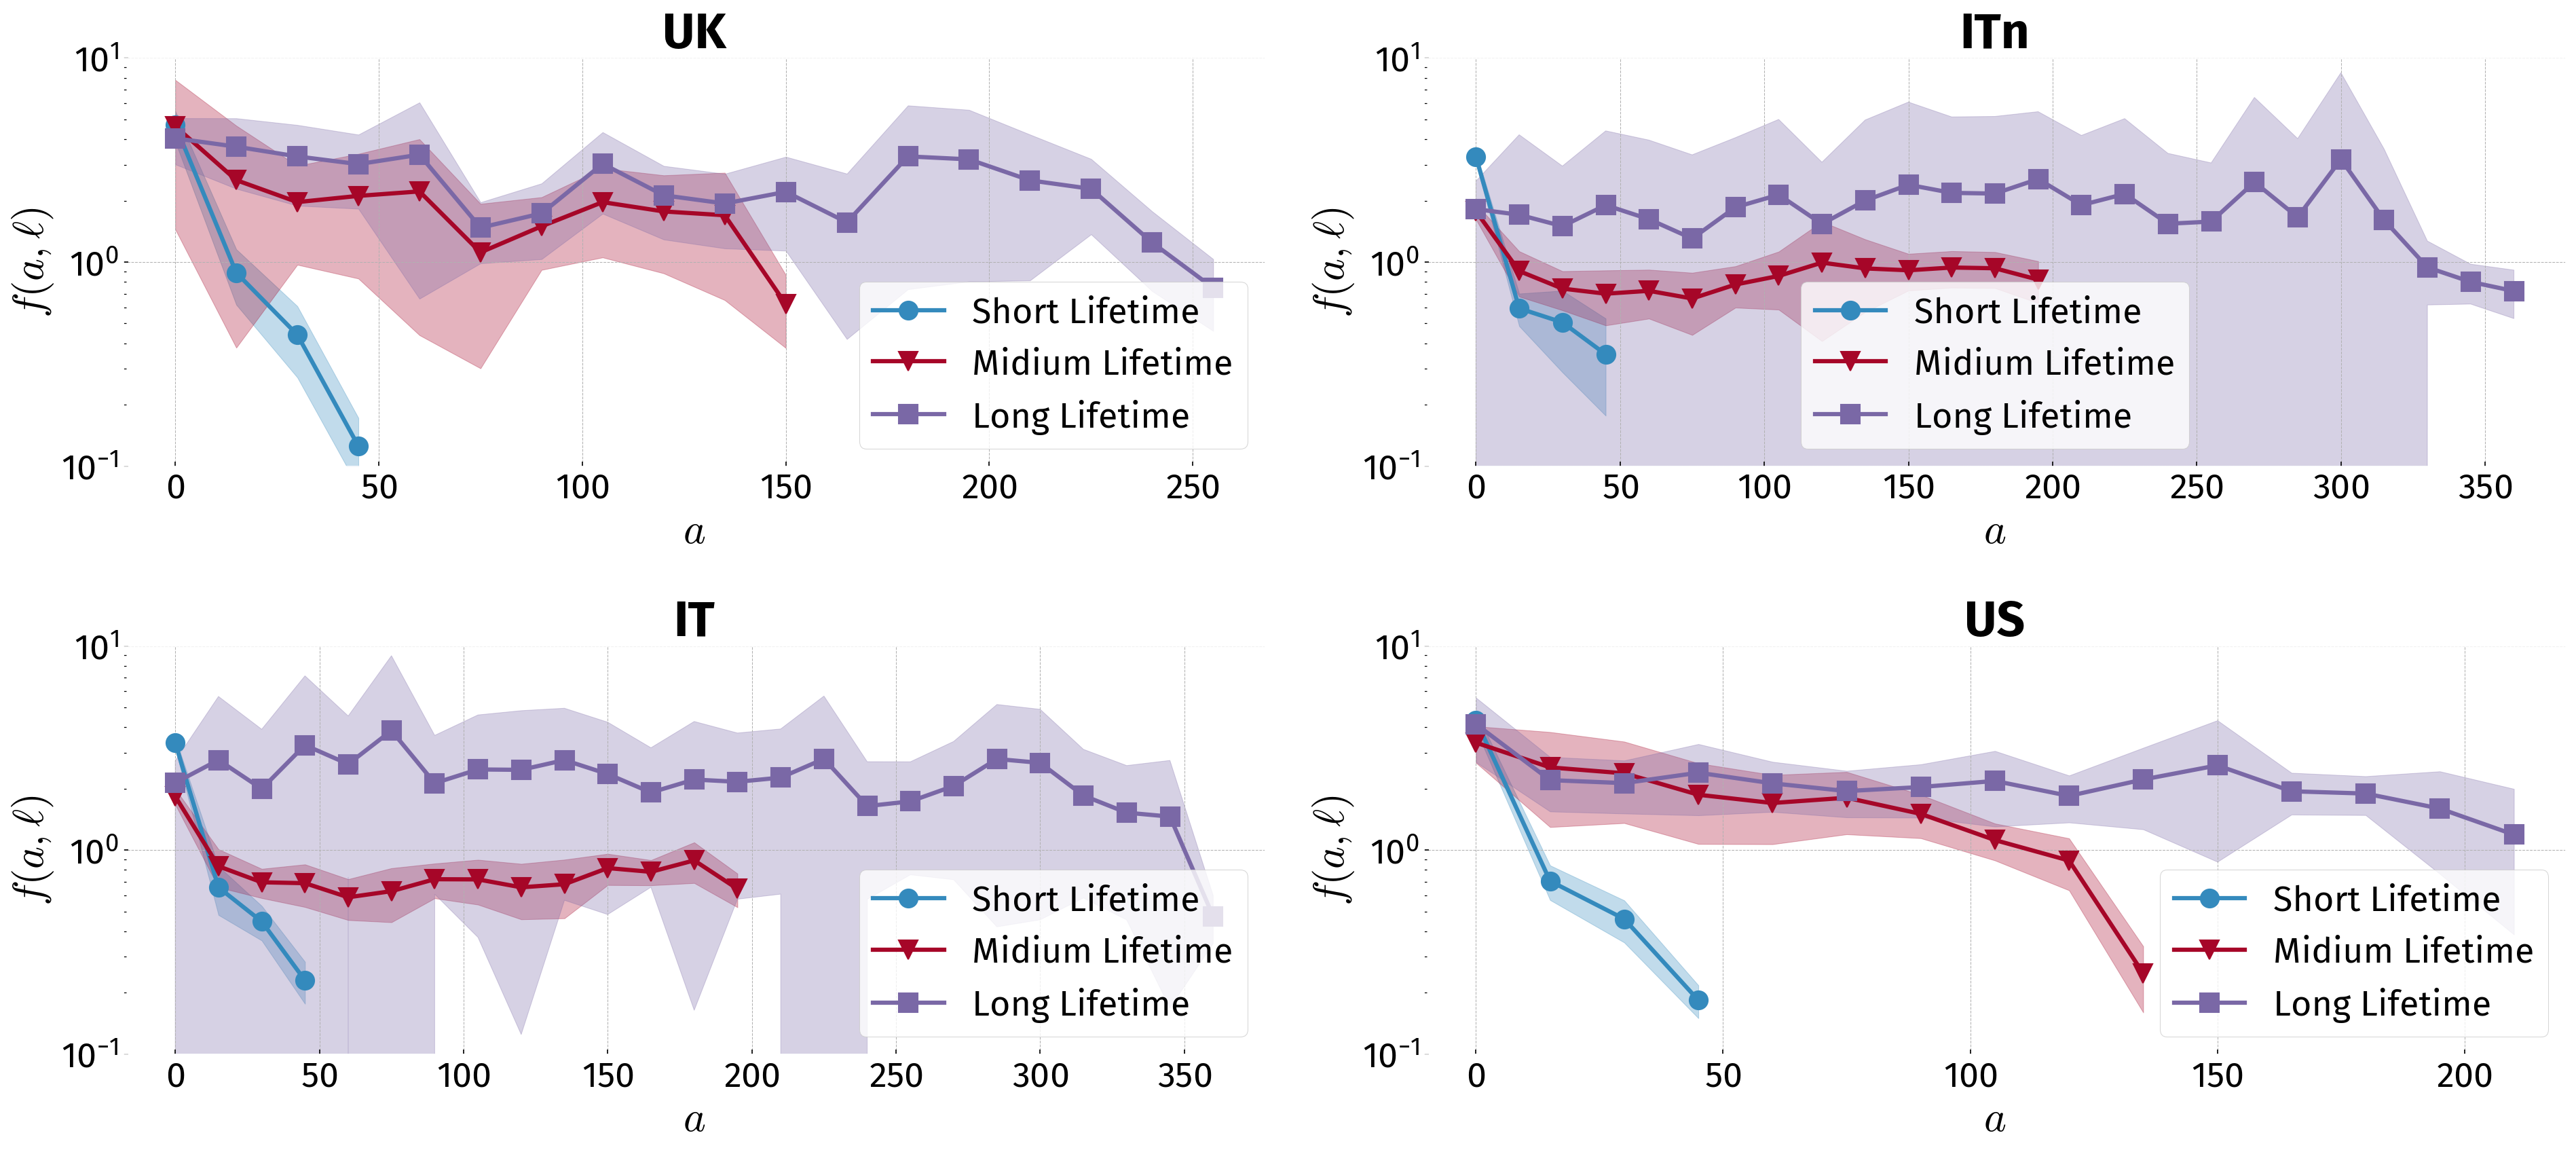

In [125]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1cit.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel('$a$')
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1cit[c][i].index * 15, fig1cit[c][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Midium Lifetime', 'Long Lifetime'][i])
        # plt.plot(fig1[c][i]['f'].index, fig1[c][i]['f']['f'], marker="X", markersize=8, ls="dashed", lw=3, color="black")
        plt.fill_between(fig1cit[c][i].index * 15, fig1cit[c][i]['below'], fig1cit[c][i]['above'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/tmp/fig1_T.pdf", dpi=200)

## Using bootstrapping

In [23]:
t0 = dt.datetime.now()
nsample = len(fig1['mit'][2]['fi'].keys())
allsamples = pd.DataFrame()
en = 0
for _ in range(100):
    egosample = np.random.choice(list(fig1['mit'][2]['fi'].keys()), size=nsample, replace=True)
    for ego in egosample:
        df = fig1['mit'][2]['fi'][ego].rename({'f': en}, axis='columns').transpose()
        allsamples = pd.concat([allsamples, df])
        en += 1
        
testing = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:13.332649


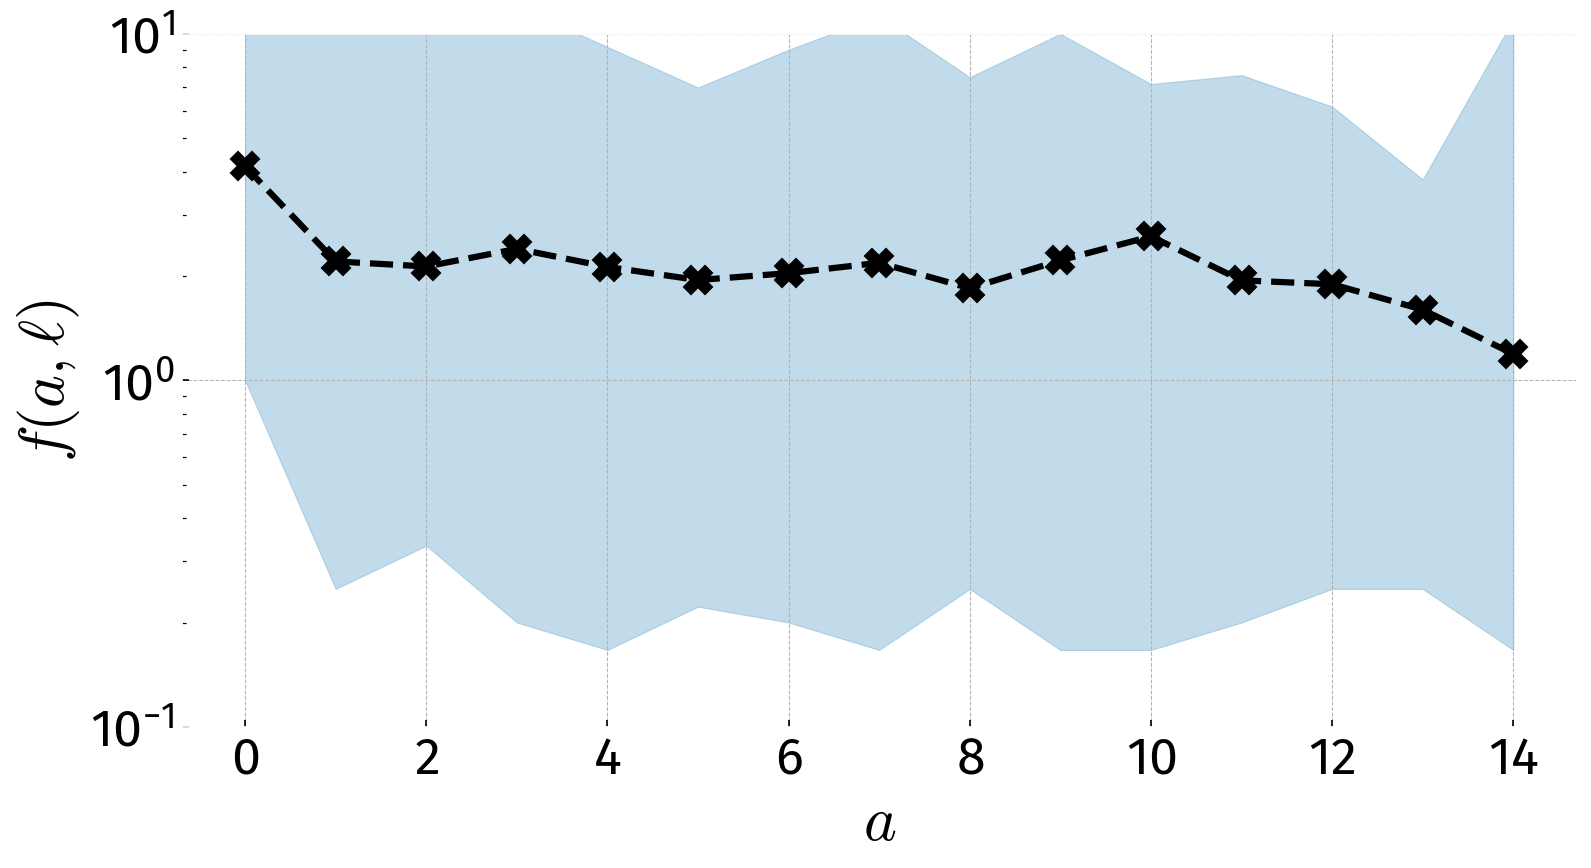

In [24]:
plt.figure(figsize=(12,6))
plt.xlabel("$a$")
plt.ylabel(r"$f(a, \ell)$")
plt.semilogy()
plt.ylim(10**(-1), 10)
plt.plot(fig1['mit'][2]['f'].index, fig1['mit'][2]['f']['f'], marker="X", markersize=13, ls="dashed", lw=3, color="black")
plt.fill_between(testing.index, testing['low'], testing['high'], color=colors[0], alpha=0.3)

In [27]:
np.random.seed(0)
t0 = dt.datetime.now()
fig1cib = {}
for c in fig1.keys():
    fig1cib[c] = {}
    ssize = []
    for i in range(3):
        nsample = len(fig1[c][i]['fi'].keys())
        allsamples = pd.DataFrame()
        en = 0
        for _ in range(100):
            egosample = np.random.choice(list(fig1[c][i]['fi'].keys()), size=nsample, replace=True)
            for ego in egosample:
                df = fig1[c][i]['fi'][ego].rename({'f': en}, axis='columns').transpose()
                allsamples = pd.concat([allsamples, df])
                en += 1
        ssize.append(len(allsamples))
        fig1cib[c][i] = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
    tf = dt.datetime.now()
    print(f'Finished {c} in {tf - t0} with sample size {ssize}')
    t0 = dt.datetime.now()

Finished uk2 in 0:00:08.970340 with sample size [2900, 2900, 2400]
Finished itb in 0:00:36.734371 with sample size [14000, 10800, 6200]
Finished it in 0:00:42.310845 with sample size [14200, 12000, 9200]
Finished mit in 0:00:34.244983 with sample size [12400, 11200, 9700]


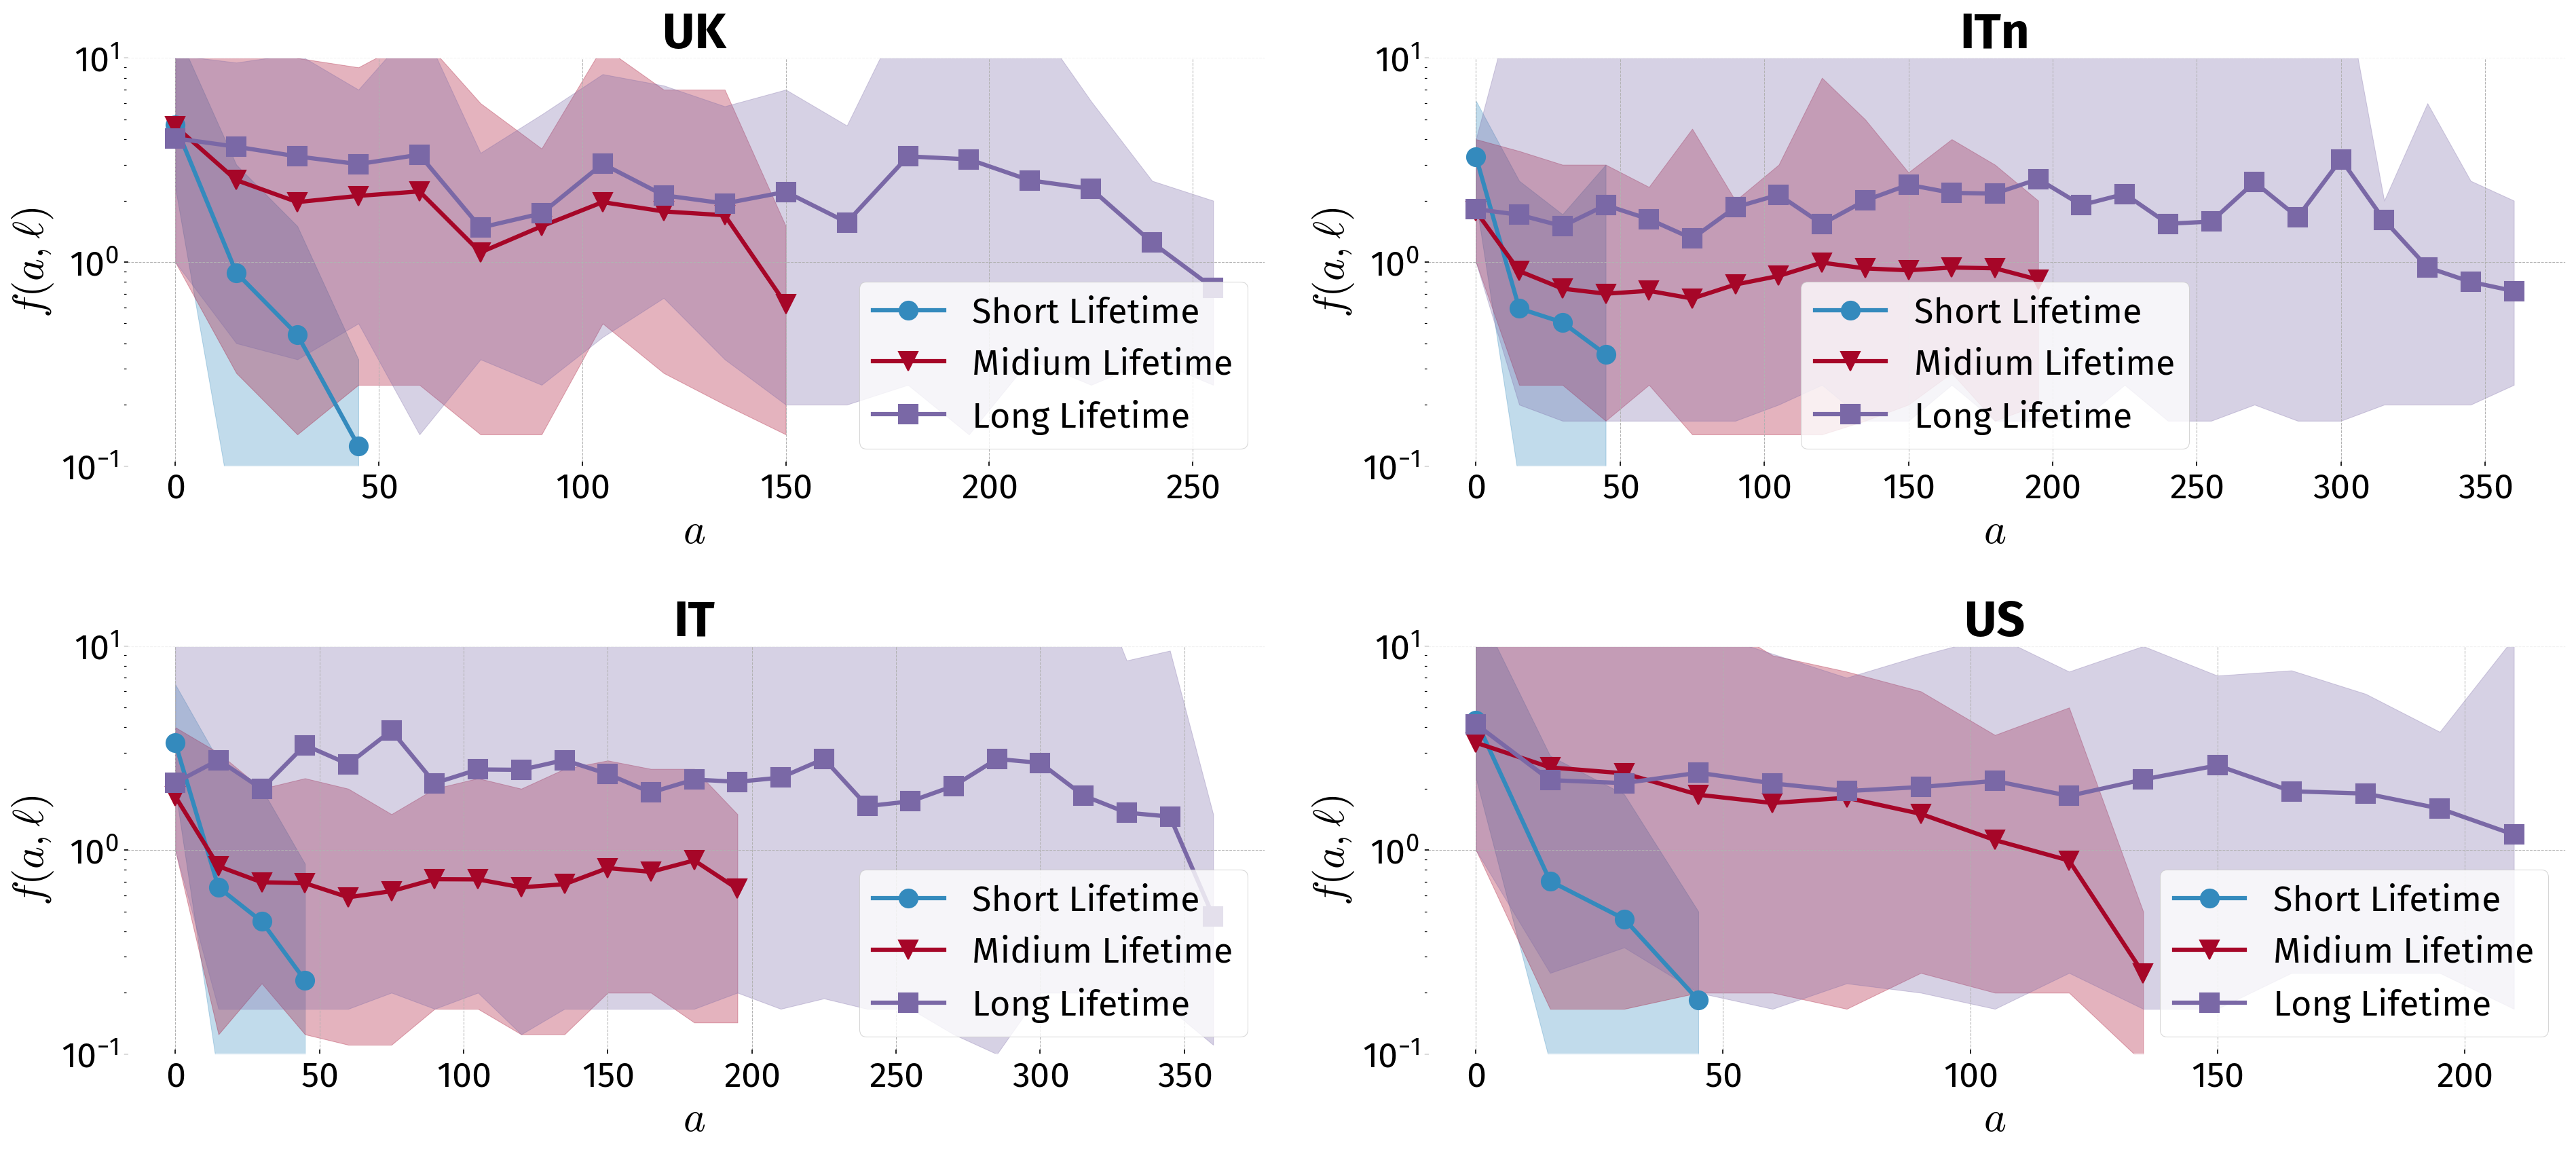

In [28]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel("$a$")
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index * 15, fig1[c][i]['f']['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Midium Lifetime', 'Long Lifetime'][i])
        plt.fill_between(fig1cib[c][i].index * 15, fig1cib[c][i]['low'], fig1cib[c][i]['high'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1

In [29]:
np.random.seed(0)
t0 = dt.datetime.now()
fig1cib = {}
for c in fig1.keys():
    fig1cib[c] = {}
    ssize = []
    for i in range(3):
        nsample = len(fig1[c][i]['fi'].keys())
        allsamples = pd.DataFrame()
        en = 0
        for _ in range(500):
            egosample = np.random.choice(list(fig1[c][i]['fi'].keys()), size=nsample, replace=True)
            for ego in egosample:
                df = fig1[c][i]['fi'][ego].rename({'f': en}, axis='columns').transpose()
                allsamples = pd.concat([allsamples, df])
                en += 1
        ssize.append(len(allsamples))
        fig1cib[c][i] = allsamples.quantile([0.025, 0.975]).transpose().rename({0.025: 'low', 0.975: 'high'}, axis='columns').sort_index()
    tf = dt.datetime.now()
    print(f'Finished {c} in {tf - t0} with sample size {ssize}')
    t0 = dt.datetime.now()

Finished uk2 in 0:00:46.911690 with sample size [14500, 14500, 12000]
Finished itb in 0:03:30.374486 with sample size [70000, 54000, 31000]
Finished it in 0:04:05.851984 with sample size [71000, 60000, 46000]
Finished mit in 0:03:01.614195 with sample size [62000, 56000, 48500]


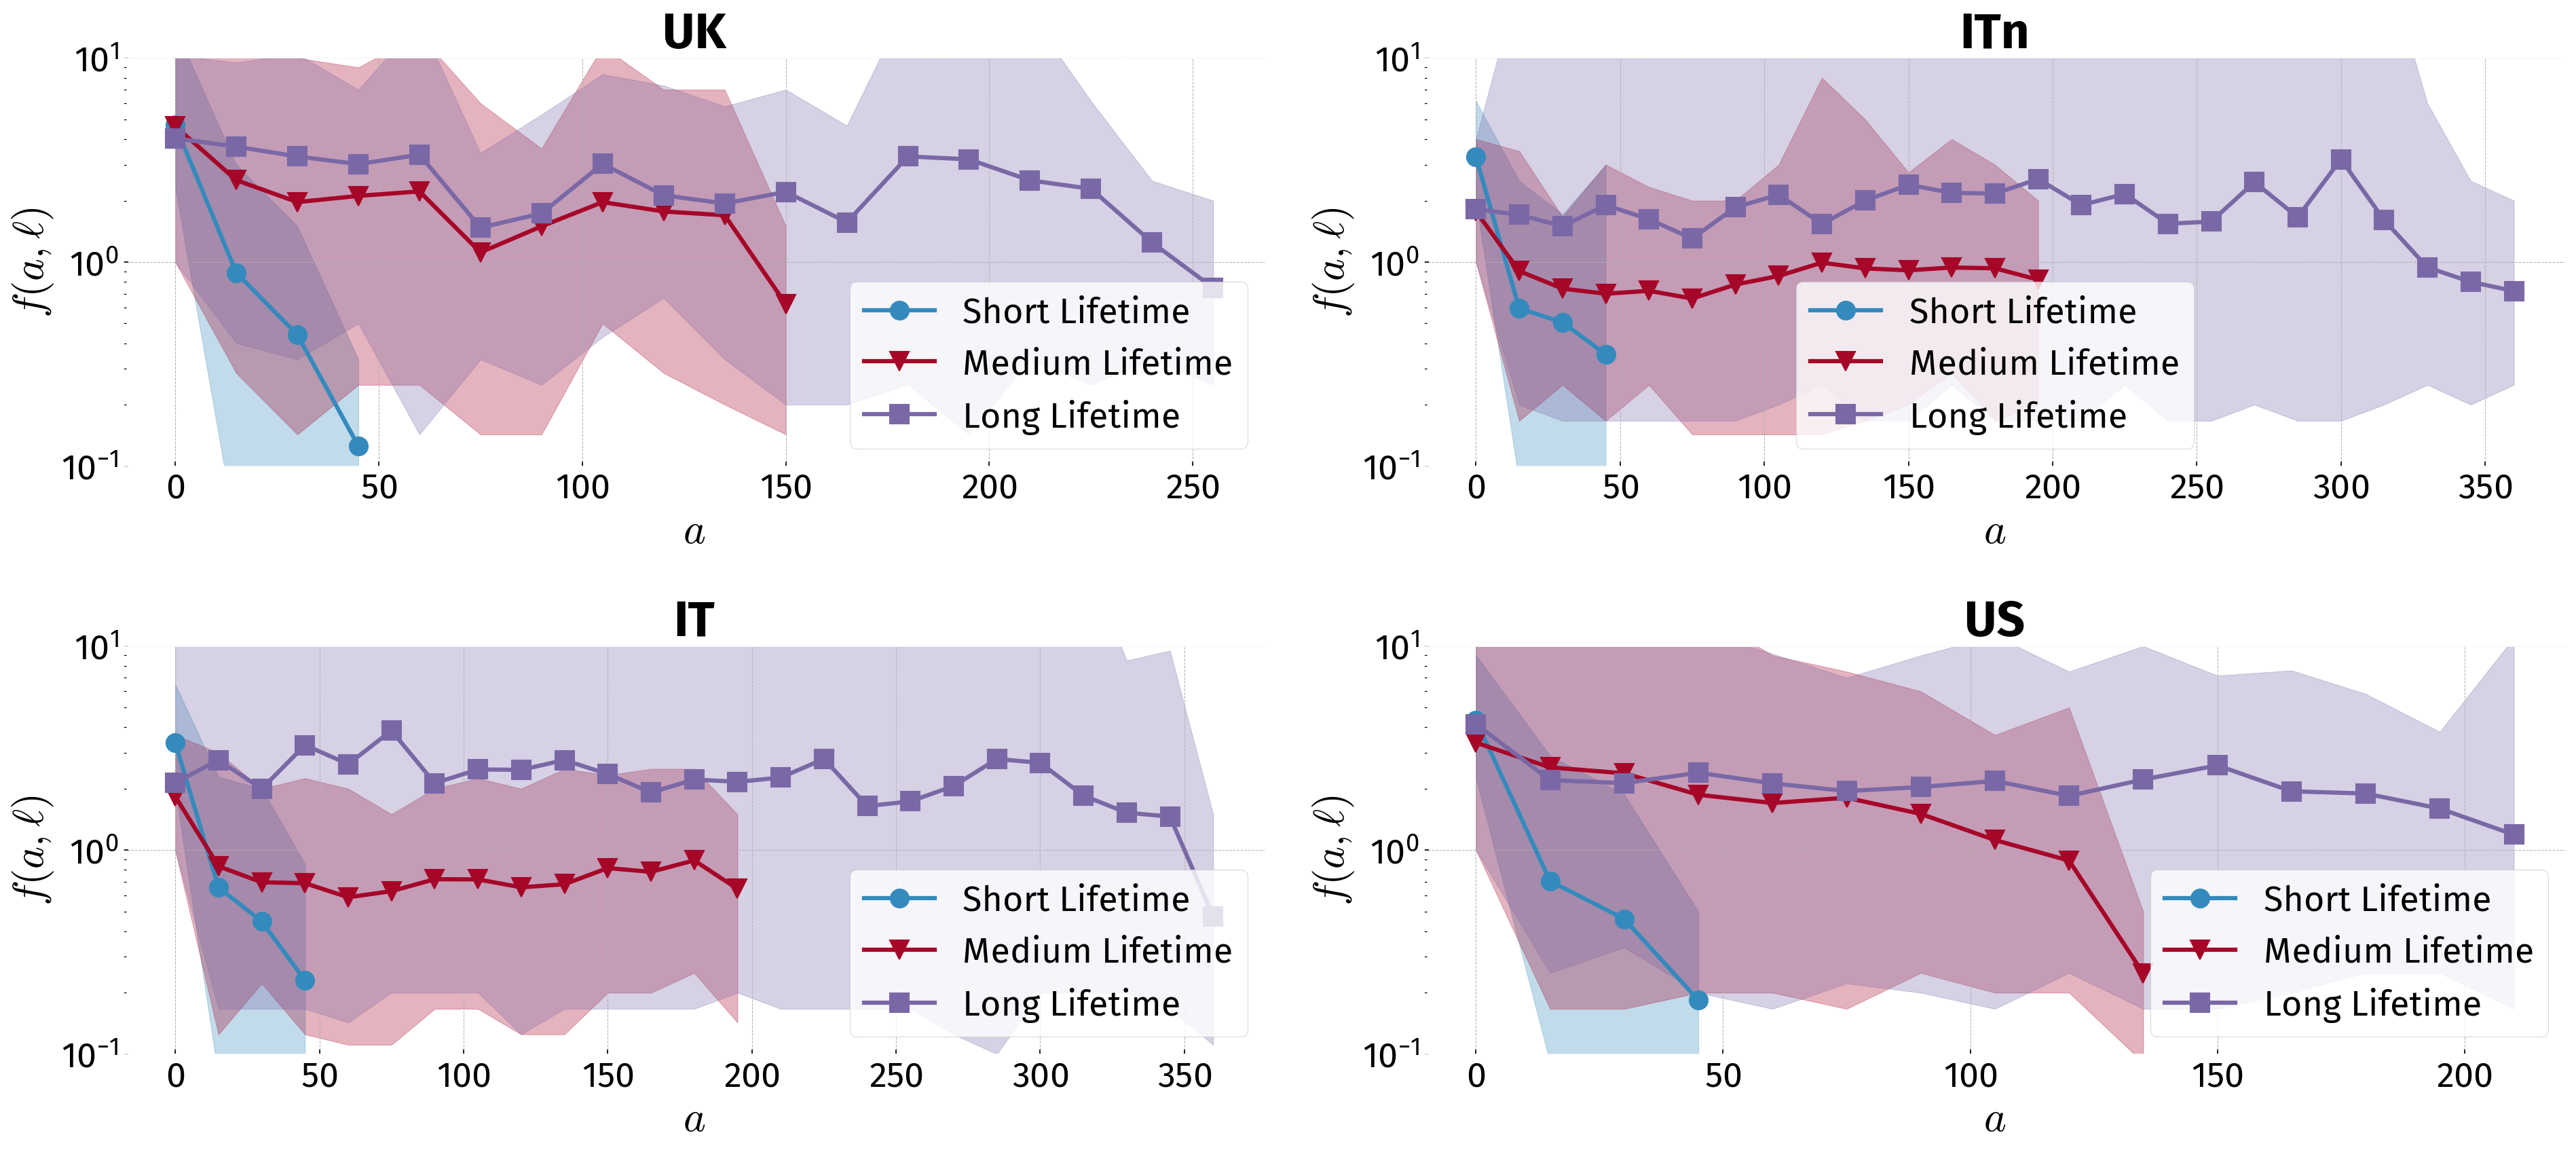

In [126]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel("$a$")
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1[c][i]['f'].index * 15, fig1[c][i]['f']['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Medium Lifetime', 'Long Lifetime'][i])
        plt.fill_between(fig1cib[c][i].index * 15, fig1cib[c][i]['low'], fig1cib[c][i]['high'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/tmp/fig1_bootstrap.pdf", dpi=200)

## Using one standard error at each point

In [119]:
t0 = dt.datetime.now()
fig1sem = {}
for c in fig1.keys():
    fig1sem[c] = {}
    for l in fig1[c].keys():
        fig1sem[c][l] = pd.DataFrame()
        dict1 = {}
        for idx in fig1[c][l]['f'].index:
            dict1[idx] = []
            for ego in fig1[c][l]['fi'].keys():
                df = fig1[c][l]['fi'][ego].copy()
                if idx in df.index:
                    dict1[idx].append(df.at[idx, 'f'])
                else:
                    continue
        for a in fig1[c][l]['f'].index:
            sem = stats.sem(dict1[a])
            m = fig1[c][l]['f'].at[a, 'f']
            fig1sem[c][l].at[a, 'f'] = m
            fig1sem[c][l].at[a, 'below'] = m - sem
            fig1sem[c][l].at[a, 'above'] = m + sem
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:00.493044


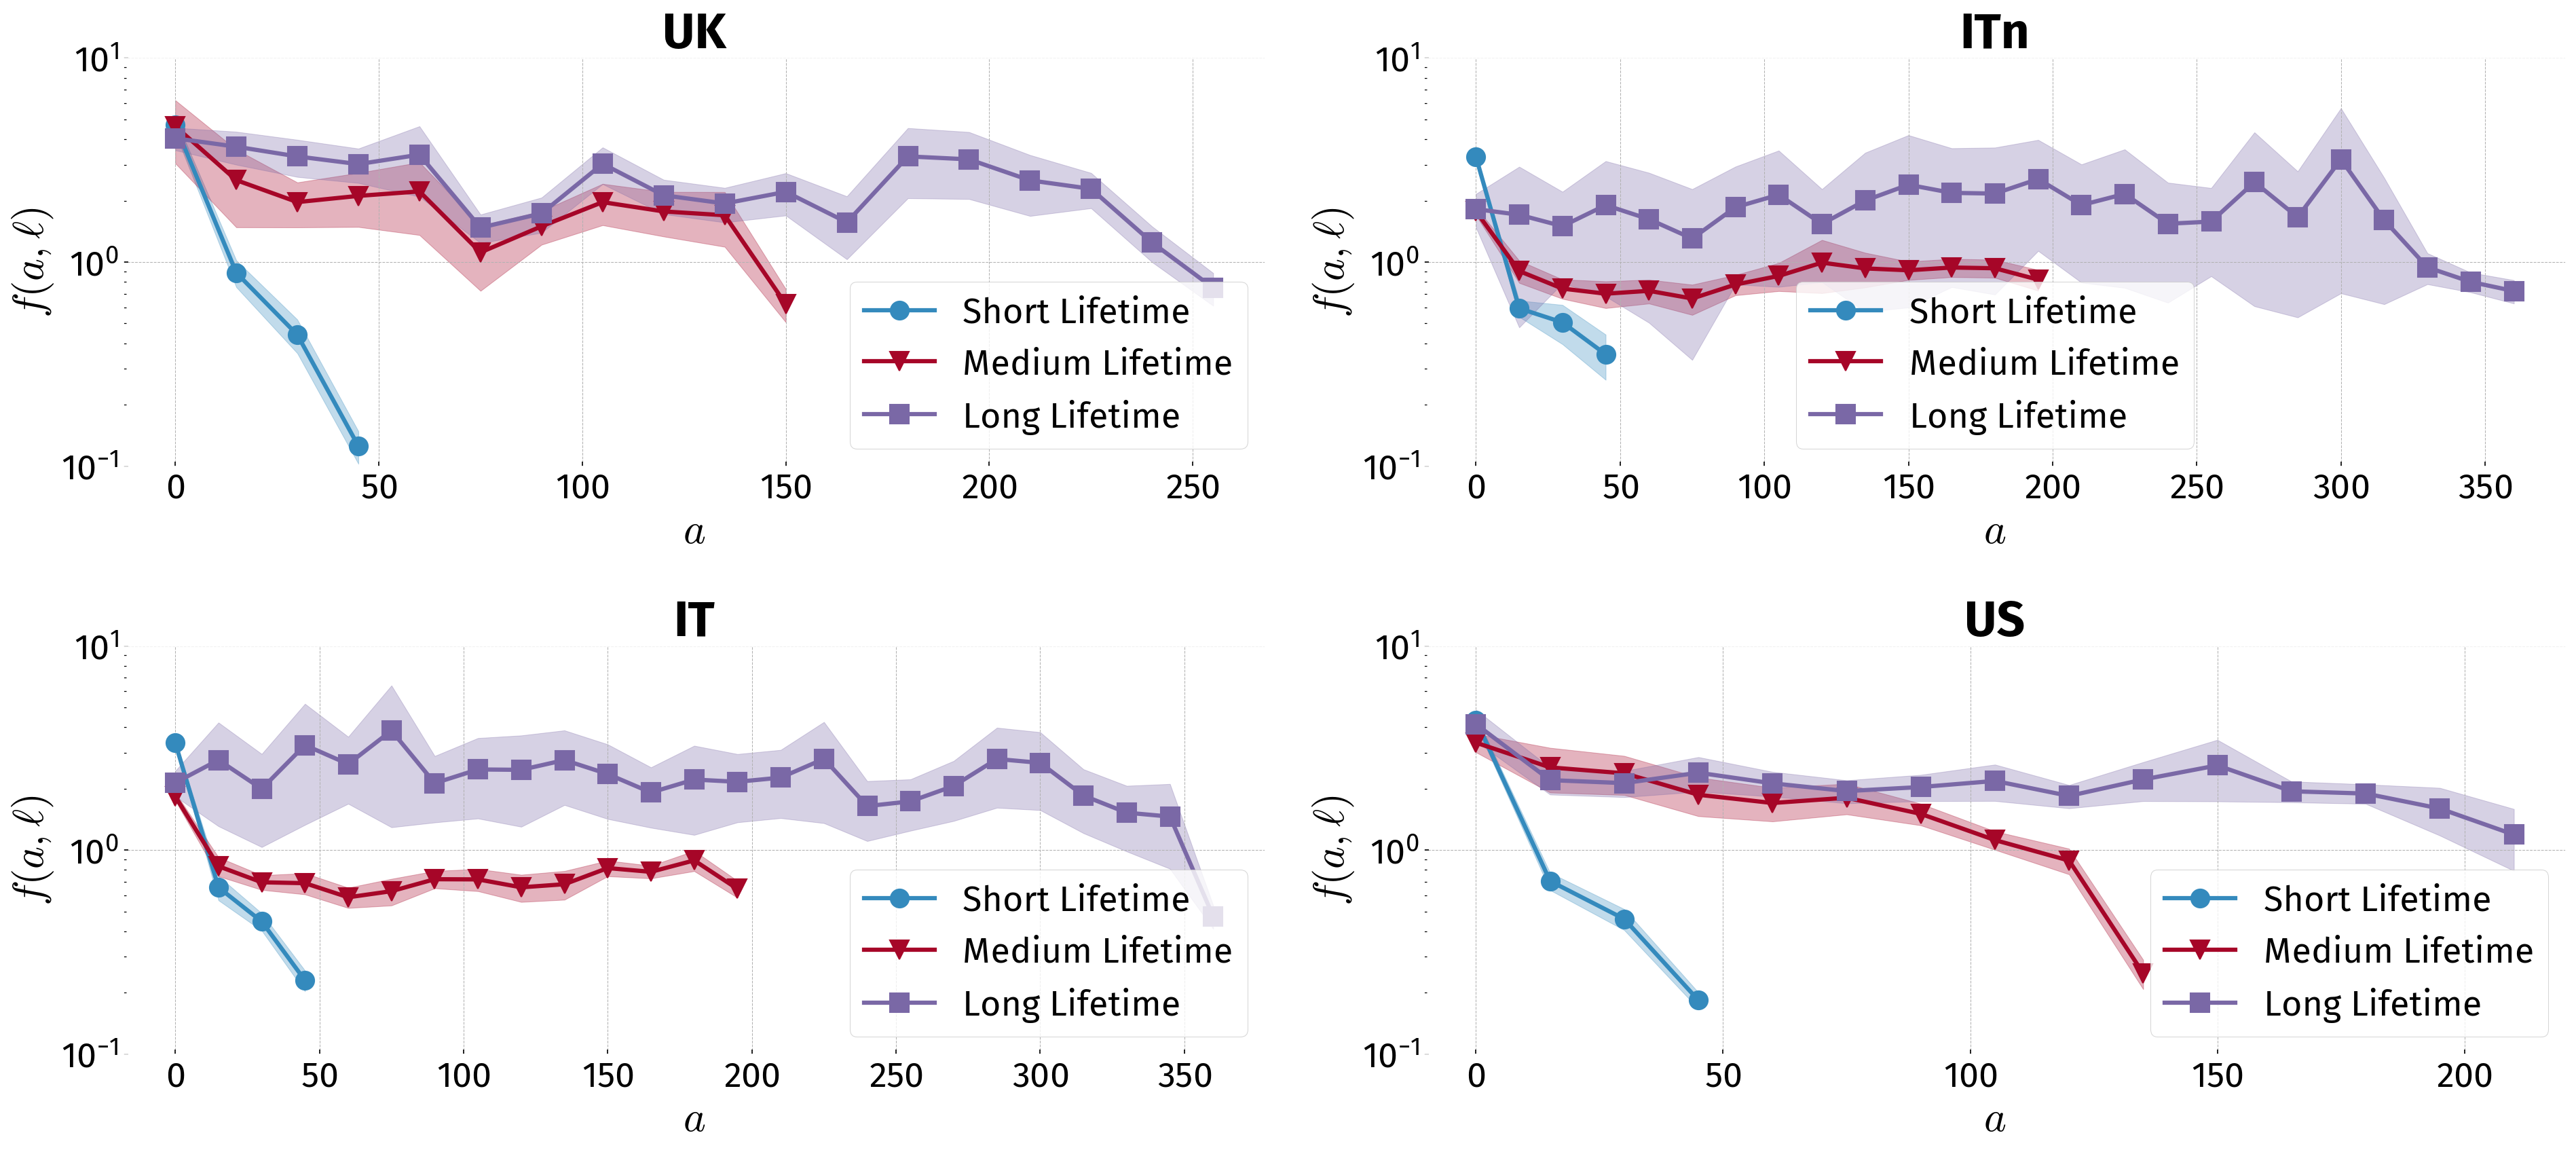

In [127]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in fig1.keys():
    plt.subplot(nr, nc, p)
    plt.title(f'{country_labels[c]}')
    plt.xlabel("$a$")
    plt.ylabel(r"$f(a, \ell)$")
    plt.semilogy()
    plt.ylim(10**(-1), 10)
    for i in range(3):
        plt.plot(fig1sem[c][i].index * 15, fig1sem[c][i]['f'], marker=markers[i], markersize=13, ls="solid", lw=3, color=colors[i], label=['Short Lifetime', 'Medium Lifetime', 'Long Lifetime'][i])
        plt.fill_between(fig1sem[c][i].index * 15, fig1sem[c][i]['below'], fig1sem[c][i]['above'], color=colors[i], alpha=0.3)
    plt.legend()
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/tmp/fig1_sem.pdf", dpi=200)

In [122]:
for c in fig1sem.keys():
    tmp = pd.DataFrame()
    for l in fig1sem[c].keys():
        df = fig1sem[c][l].copy()
        df.columns = [f'l{int(l)}', f'lbe{int(l)}', f'lab{int(l)}']
        if len(tmp) == 0:
            tmp = tmp.append(df)
        else:
            tmp = tmp.merge(df, left_index=True, right_index=True, how='outer')
    tmp.index.rename('a', inplace=True)
    tmp.fillna('nan', inplace=True)
    tmp.to_csv(f"../commpatterns/PNAS_paper/SI/figs/fig1_{c}.dat", header=True, sep="\t")

/tmp/ipykernel_11041/1925264004.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(df)
/tmp/ipykernel_11041/1925264004.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(df)
/tmp/ipykernel_11041/1925264004.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(df)
/tmp/ipykernel_11041/1925264004.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(df)


# Medium Italian lifetimes

In [31]:
hell = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    df = calls[c].copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    lf = df.groupby('ea')[['aclock']].max().rename({'aclock': 'ell'}, axis='columns')
    lf = lf.loc[(lf['ell'] >= limits[c][1][0]) & (lf['ell'] <= limits[c][1][1])]
    H = {}
    for ell in lf['ell']:
        H[ell] = H.get(ell, 0) + 1
    tmp = pd.DataFrame.from_dict(H, orient='index', columns=['H']).sort_index()
    tmp['pmf'] = tmp['H'].div(sum(tmp['H']))
    hell[c] = tmp.copy()

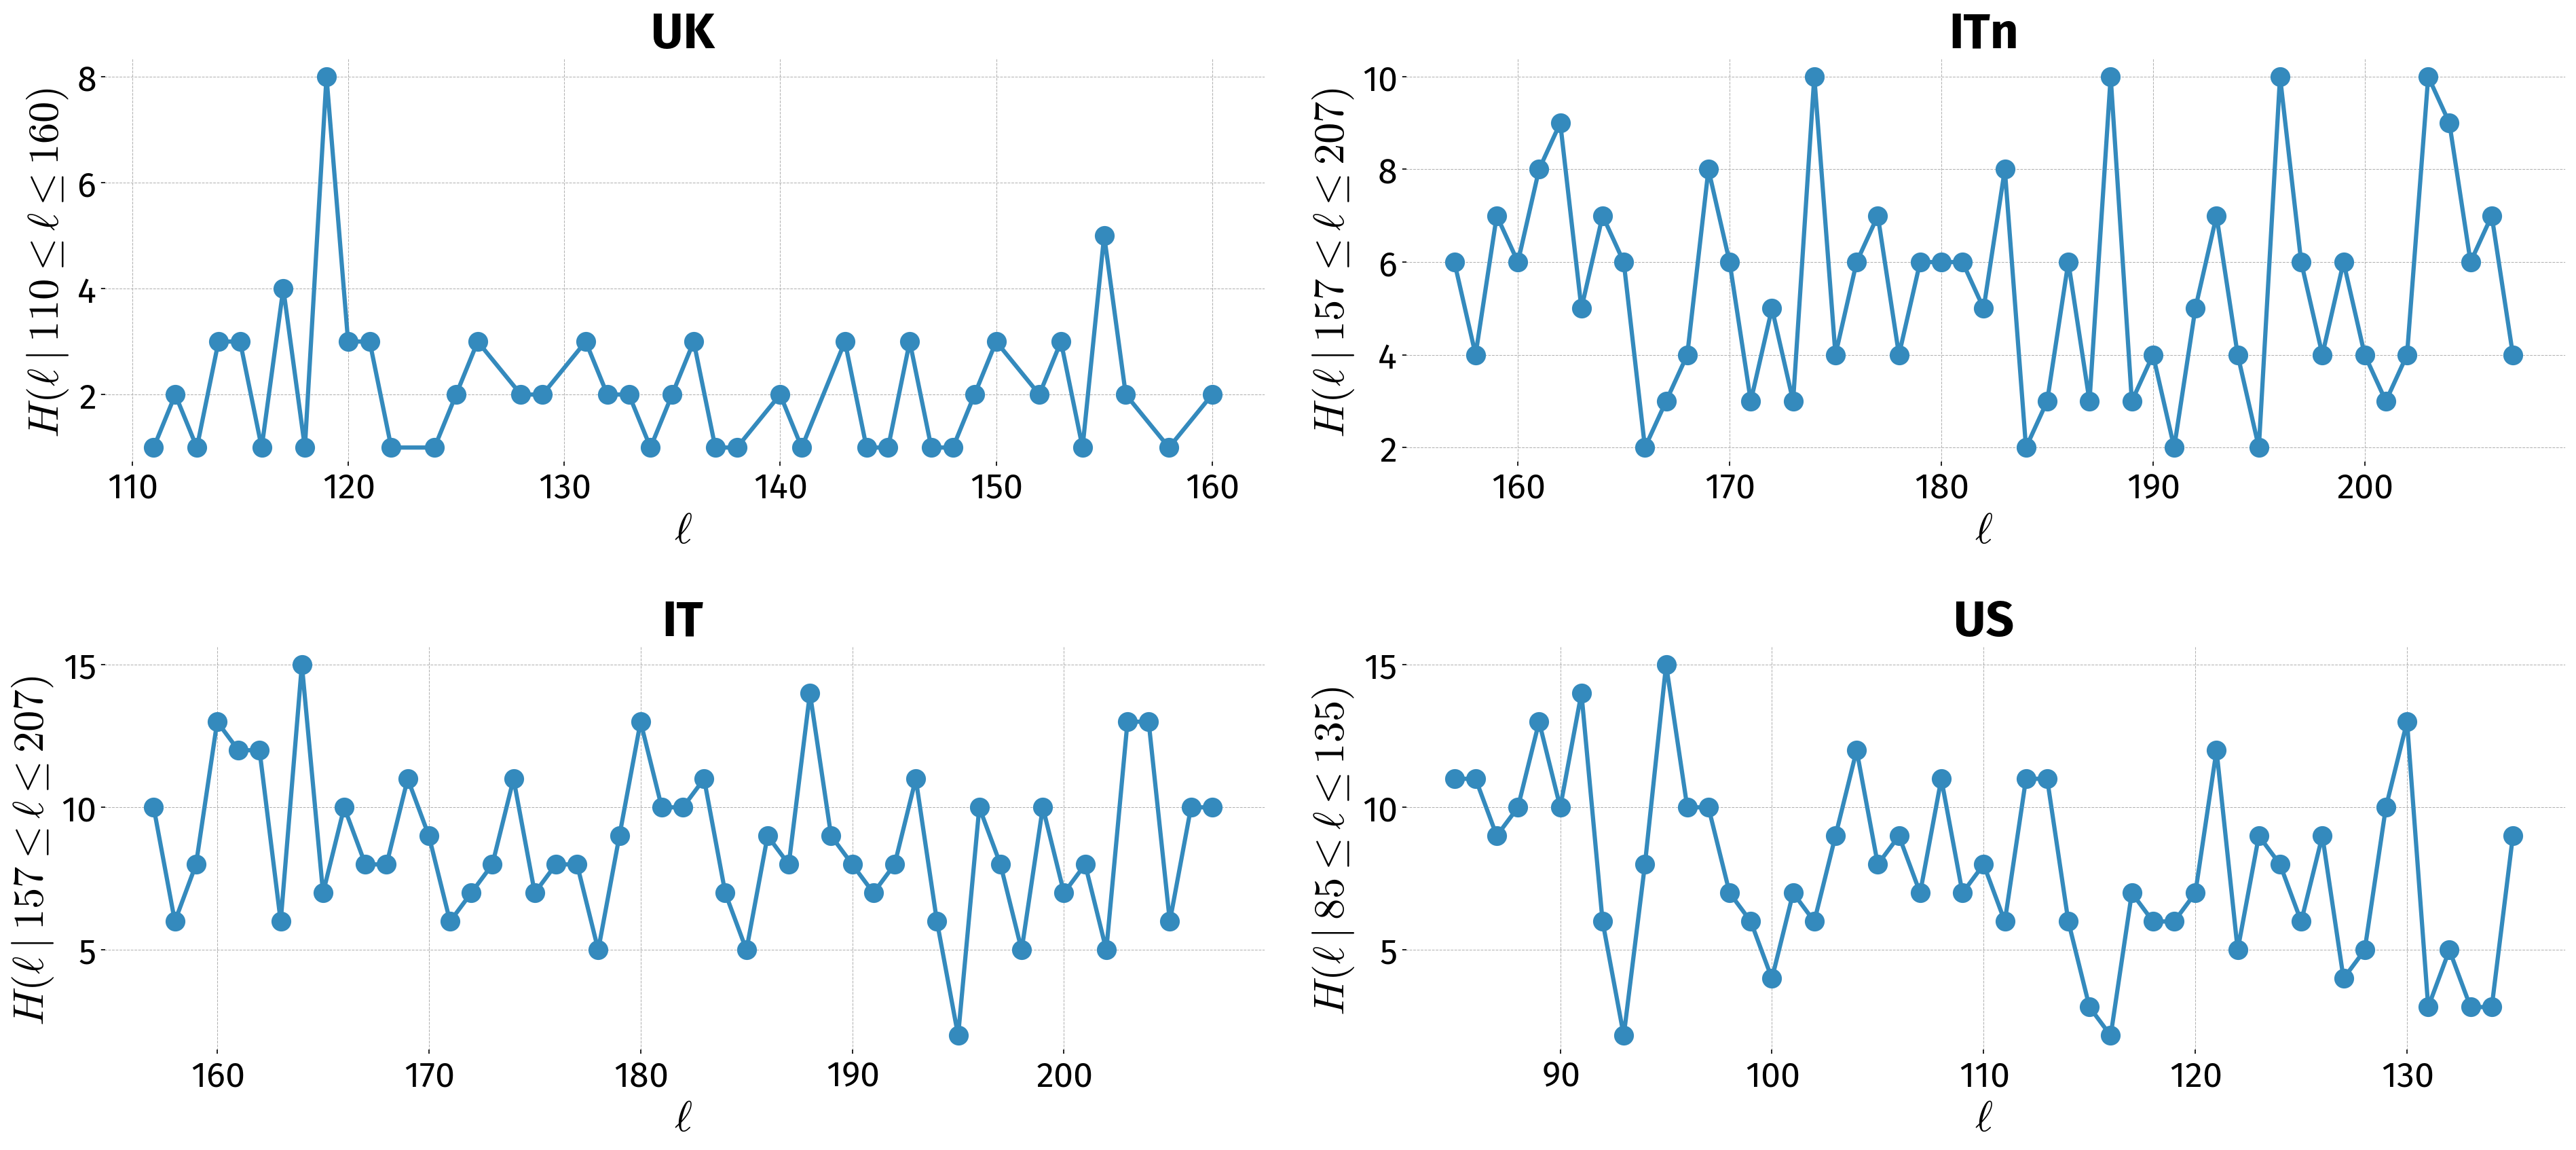

In [32]:
nc = 2
nr = 2
plt.figure(figsize=(13*nc,6*nr))
p = 1
for c in hell.keys():
    plt.subplot(nr, nc, p)
    plt.title(f"{country_labels[c]}")
    plt.xlabel("$\ell$")
    plt.ylabel(fr"$H(\ell \mid {limits[c][1][0]} \leq \ell \leq {limits[c][1][1]})$")
    plt.plot(hell[c].index, hell[c]['H'], marker="o", markersize=13, ls="solid", lw=3)
    p += 1
    plt.tight_layout()
# plt.savefig("/home/vsvh/dump/HellMedium.pdf", dpi=200)

## Alternative limits for Italian medium lifetimes

In [33]:
t0 = dt.datetime.now()
fig1alt = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    fig1alt[c] = {}
    for i in range(3):
        fig1alt[c][i] = pc.get_fal(calls[c], limits2[c][i][0], limits2[c][i][1], 15, countalters=True)
print(f'Took {dt.datetime.now() - t0}')

Took 0:00:02.459877


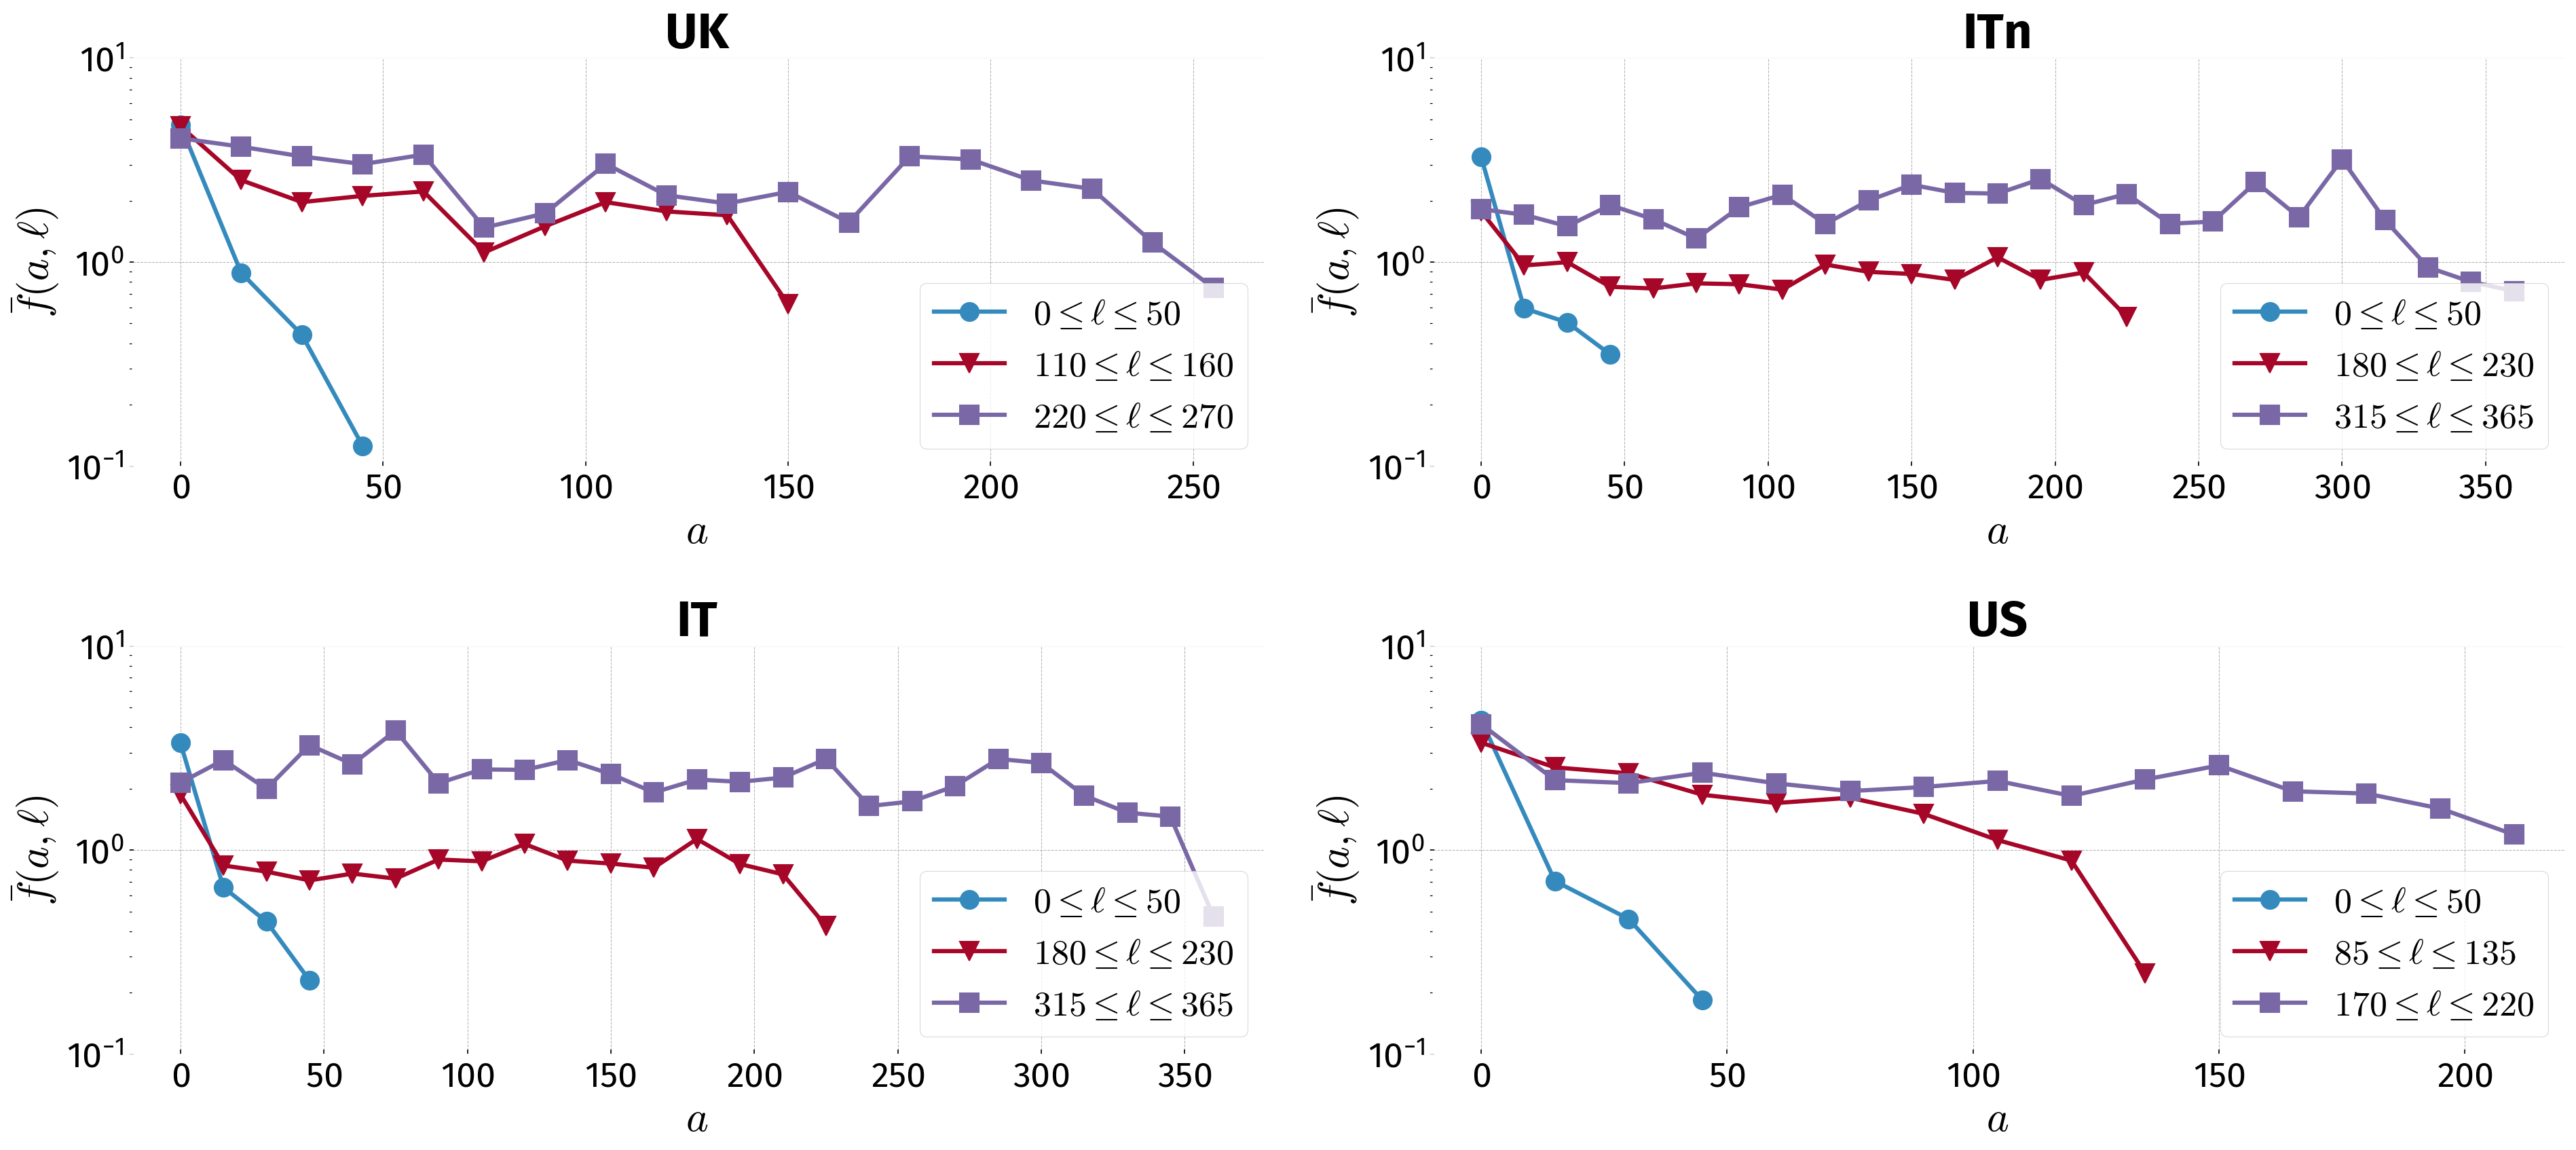

In [34]:
nc = 2
nr = 2
plt.figure(figsize=(nc*13, nr*6))
p = 1
for c in ['uk2', 'itb', 'it', 'mit']:
    plt.subplot(nr, nc, p)
    plt.title(f"{country_labels[c]}")
    plt.ylim(10**(-1), 10**1)
    plt.semilogy()
    plt.xlabel(fr'$a$')
    plt.ylabel(r'$\bar{f}(a, \ell)$')
    for i in range(3):
        plt.plot(fig1alt[c][i]['f'].index * 15, fig1alt[c][i]['f']['f'], marker=markers[i], ls="solid", lw=3, markersize=13, c=colors[i], label=fr'${limits2[c][i][0]}\leq \ell \leq {limits2[c][i][1]}$')
    plt.legend()
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/fig1alt.pdf", dpi=200)

## Different values in the medium range of lifetime

In [35]:
limits2

{'uk2': [(0, 50), (110, 160), (220, 270)],
 'itb': [(0, 50), (180, 230), (315, 365)],
 'it': [(0, 50), (180, 230), (315, 365)],
 'mit': [(0, 50), (85, 135), (170, 220)]}

In [36]:
lfrange = {}
lfrange['itb'] = [(130, 180), (140, 190), (150, 200), (157, 207), (160, 210), (170, 220), (180, 230)]
lfrange['it'] = lfrange['itb']

In [37]:
diffrange = {}
for c in ['itb', 'it']:
    diffrange[c] = {}
    for i in range(len(lfrange[c])):
        diffrange[c][i] = pc.get_fal(calls[c], lfrange[c][i][0], lfrange[c][i][1], 15, countalters=True)

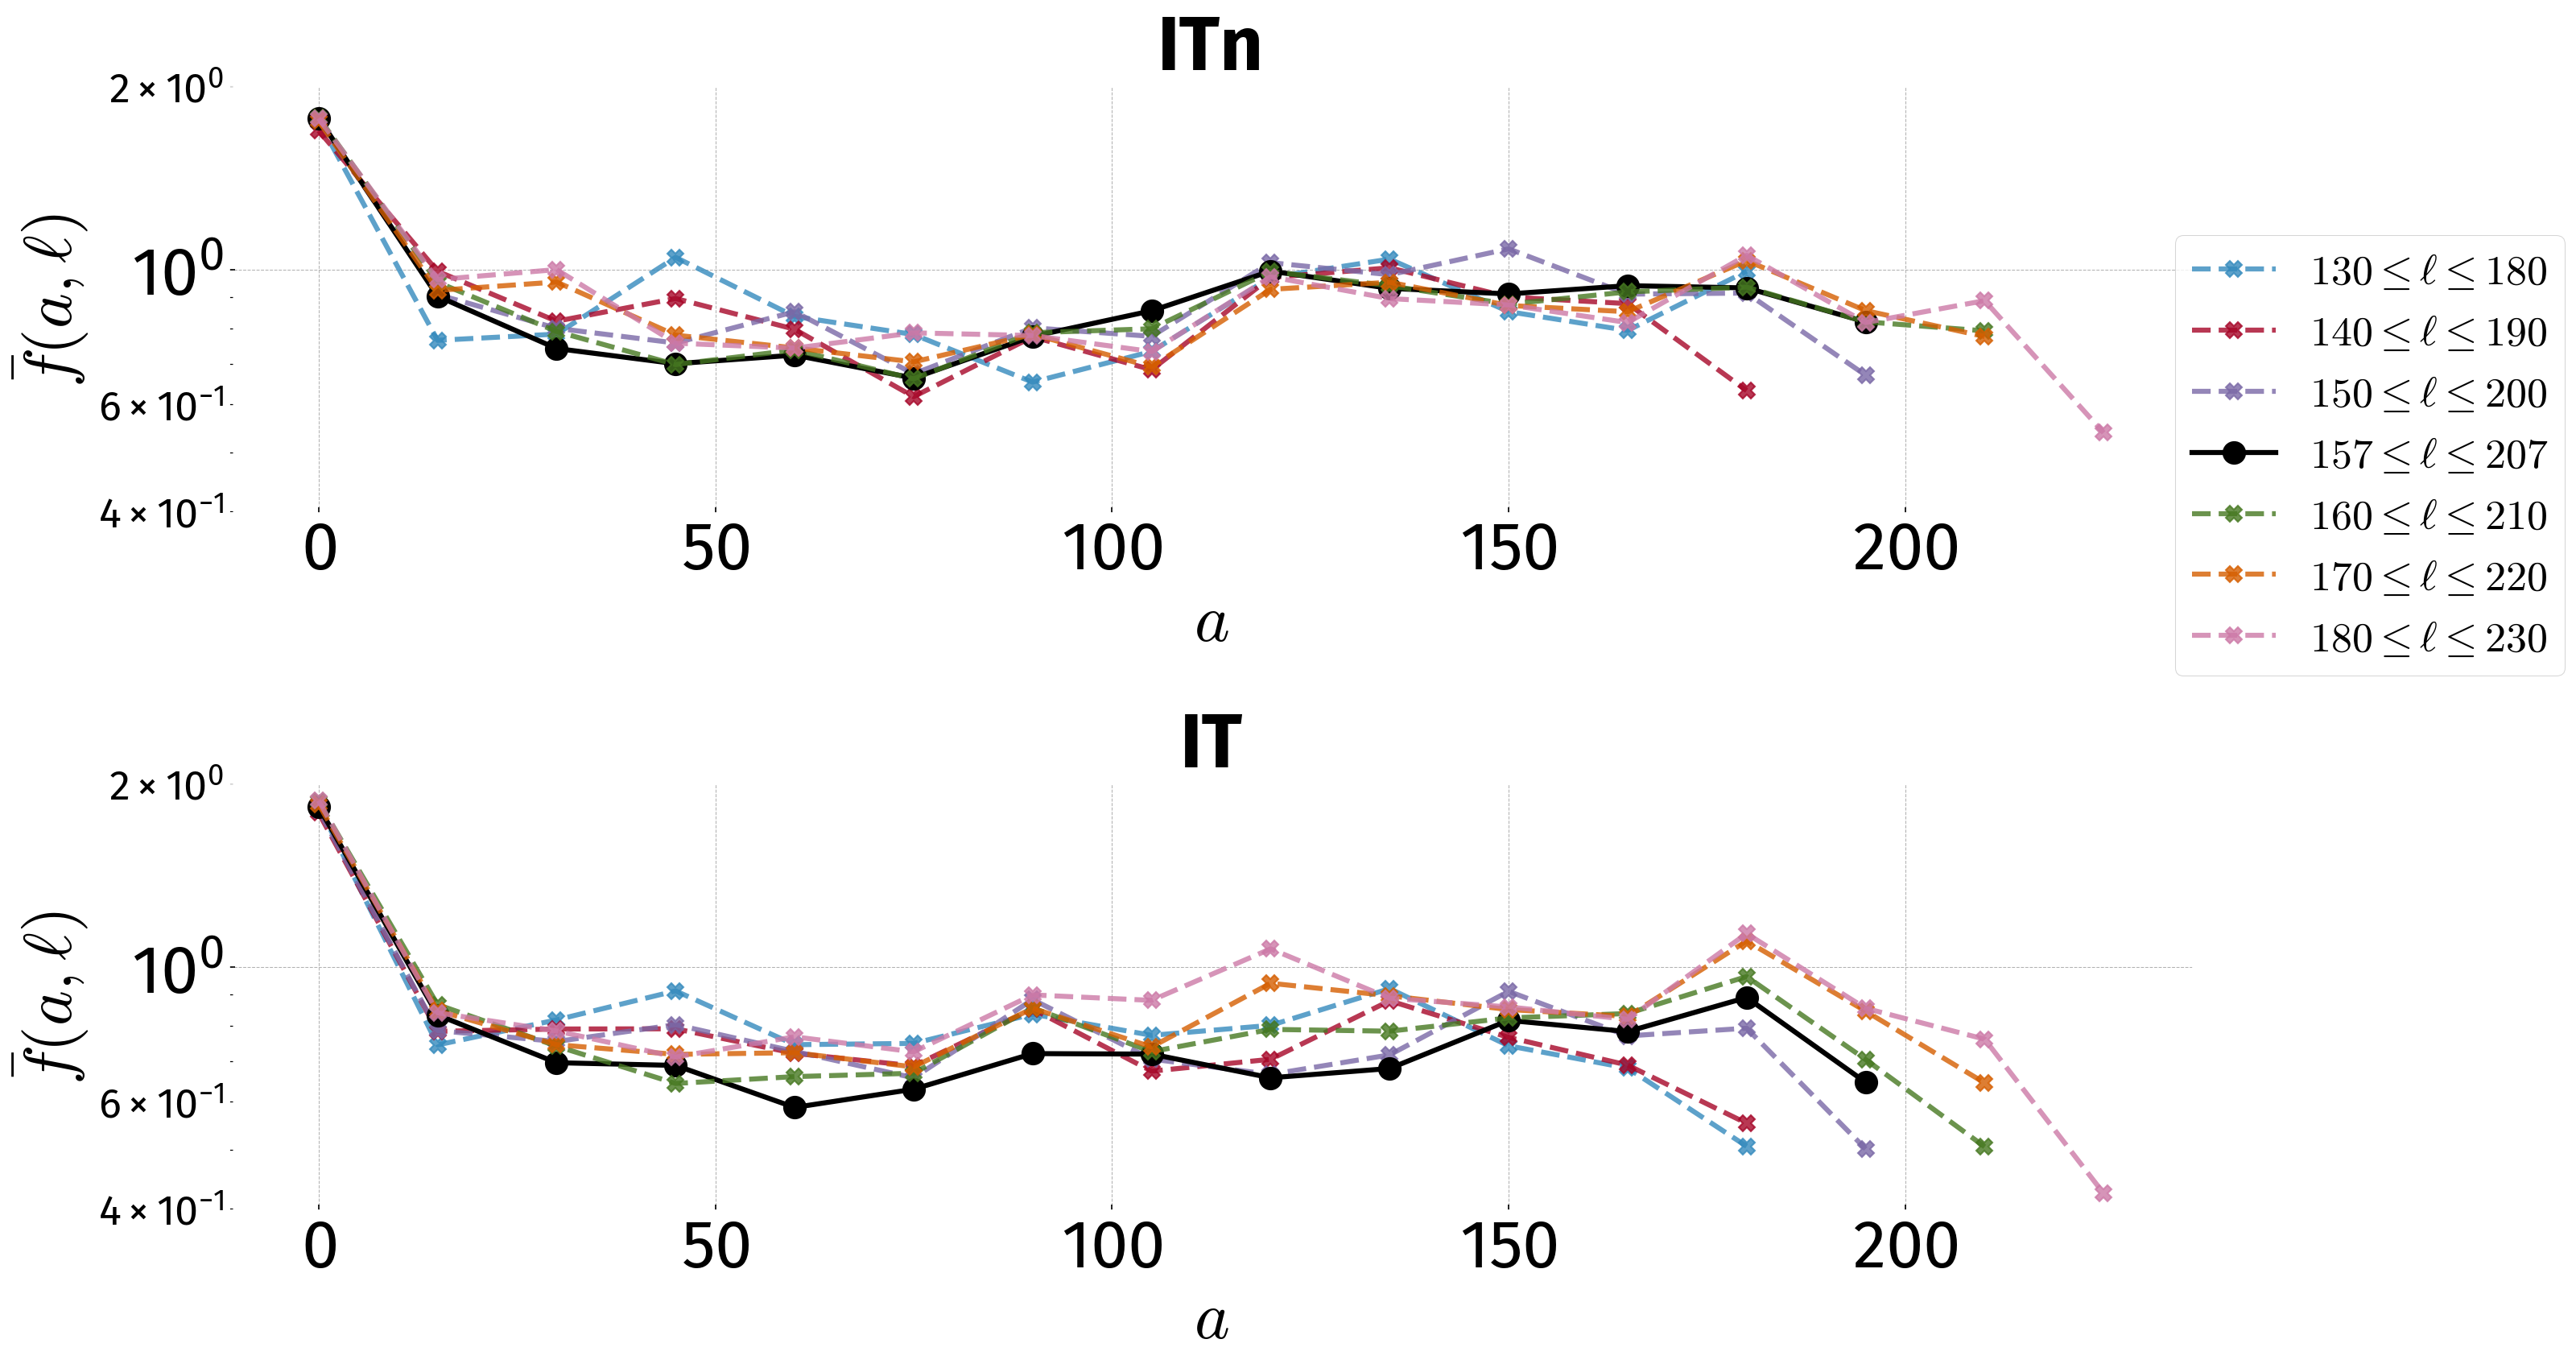

In [38]:
nc = 1
nr = 2
plt.figure(figsize=(nc*22, nr*6))
p = 1
for c in diffrange.keys():
    plt.subplot(nr, nc, p)
    plt.title(country_labels[c], fontsize=45)
    plt.xlabel("$a$", fontsize=40)
    plt.ylabel(r"$\bar{f}(a, \ell)$", fontsize=40)
    plt.yticks(fontsize=40)
    plt.xticks(fontsize=40)
    plt.semilogy()
    plt.ylim(10**(-0.4), 2)
    for i in range(len(lfrange[c])):
        if i  == 3:
            plt.plot(diffrange[c][i]['f'].index * 15, diffrange[c][i]['f']['f'], marker="o", ls='solid', markersize=13, lw=3, color="black", label=fr'${lfrange[c][i][0]} \leq \ell \leq {lfrange[c][i][1]}$')
        else:
            plt.plot(diffrange[c][i]['f'].index * 15, diffrange[c][i]['f']['f'], marker="X", ls='dashed', markersize=10, alpha=0.8, lw=3, label=fr'${lfrange[c][i][0]} \leq \ell \leq {lfrange[c][i][1]}$')
    if p == 1:
        plt.legend(bbox_to_anchor=(1.2, 0.7), fontsize=25)
    plt.tight_layout()
    p += 1
# plt.savefig("/home/vsvh/dump/mediumell2.pdf", dpi=150)

# Histogram of $b_i$

In [72]:
bhist = {}
for c in fig1.keys():
    bhist[c] = {}
    for lamb in fig1[c].keys():
        bhist[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve = fig1[c][lamb]['fi'][ego].copy()
            if len(curve > 1):
                b = pc.get_b_slopes(curve)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist[c][lamb].append(b[1][1])

/home/vsvh/docs/GMU/research/comm_patterns_git/phonecalls.py:797: RuntimeWarning: invalid value encountered in double_scalars
  slope = (yf - yo) / (xf - xo)


In [73]:
def histogram(array, bins, log=False, usezero=False, midpoint=False):
    xl = sorted(list(array))
    xo = xl[0]
    xf = xl[-1]
    if log:
        lmu = np.log10(xf / xo) / bins
        mu = 10**lmu
    dx = (xf - xo) / bins
    h = {}
    if log:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = np.log10(x / xo) // lmu
                h[i] = h.get(i, 0) + 1
    else:
        for x in xl:
            if x == xf:
                h[bins - 1] = h.get(bins - 1, 0) + 1
            else:
                i = int((x - xo) // dx)
                h[i] = h.get(i, 0) + 1
    df = pd.DataFrame.from_dict(h, orient='index', columns=['h']).sort_index()
    if usezero:
        df = df.reindex(range(bins), fill_value=0)
    df['pmf'] = df['h'].div(sum(df['h']))
    df['pdf'] = df['pmf'] / dx
    for i in df.index:
        if log:
            df.at[i, 'label'] = xo*(mu**i)
        else:
            if midpoint:
                df.at[i, 'label'] = xo + (dx * (i + 0.5))
            else:
                df.at[i, 'label'] = xo + (dx * (i))
    return df

In [98]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(1,3):
        H = histogram(bhist[c][lamb], 10, log=True, usezero=True)
        avg = np.mean(bhist[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pdf', 'label']]
        miny = sorted([i for i in H['pdf'] if i > 0])[0]
        H['pdf'] = H['pdf'].map(lambda i: 10**(-2.5) if i == 0 else i)
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk2========================
\addplot[dashed, squirtle, line width = 4] coordinates {(1.8286789428415045, 0.001) (1.8286789428415045, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.264014332228618, 0.001) (2.264014332228618, 1)};
=====================itb========================
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9375855477034395, 0.001) (0.9375855477034395, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1258008182855719, 0.001) (1.1258008182855719, 1)};
=====================it========================
\addplot[dashed, squirtle, line width = 4] coordinates {(0.849452966316839, 0.001) (0.849452966316839, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.5196046631573819, 0.001) (1.5196046631573819, 1)};
=====================mit========================
\addplot[dashed, squirtle, line width = 4] coordinates {(1.7382532705763836, 0.001) (1.7382532705763836, 1)};
\addplot[dashed, ekans, line width = 4] coordina

In [99]:
tmp

uk2y1     uk2x1     uk2y2     uk2x2     itby1     itbx1     itby2  \
0  0.098236  0.469388  0.068325  0.555556  0.067122  0.250000  0.112089   
1  0.130981  0.643455  0.204975  0.712134  0.167805  0.322017  0.155200   
2  0.294707  0.882072  0.273301  0.912844  0.839027  0.414779  0.103466   
3  0.163726  1.209177  0.136650  1.170122  0.503416  0.534263  0.068978   
4  0.065491  1.657586  0.136650  1.499911  0.369172  0.688167  0.034489   
5  0.065491  2.272282  0.204975  1.922650  0.704782  0.886405  0.017244   
6  0.065491  3.114930  0.136650  2.464533  0.234927  1.141749  0.003162   
7  0.032745  4.270064  0.341626  3.159142  0.234927  1.470650  0.003162   
8  0.003162  5.853566  0.068325  4.049521  0.201366  1.894295  0.003162   
9  0.032745  8.024290  0.068325  5.190847  0.134244  2.439980  0.008622   

       itbx2      ity1      itx1      ity2       itx2     mity1      mitx1  \
0   0.266667  0.180426  0.272727  0.090815   0.266667  0.037593   0.333333   
1   0.411190  0.380900  0.360975  0.094059   0.434176  0.123519   0.496451   
2   0.634040  0.541279  0.477777  0.038921   0.706908  0.204074   0.739390   
3   0.977665  0.441042  0.632374  0.019460   1.150959  0.080556   1.101212   
4   1.507523  0.400948  0.836994  0.025947   1.873944  0.048333   1.640093   
5   2.324545  0.140332  1.107823  0.009730   3.051080  0.026852   2.442676   
6   3.584361  0.080190  1.466287  0.003243   4.967646  0.010741   3.638005   
7   5.526951  0.160379  1.940740  0.003162   8.088120  0.010741   5.418271   
8   8.522352  0.020047  2.568714  0.003243  13.168751  0.016111   8.069715   
9  13.141147  0.020047  3.399884  0.003243  21.440828  0.010741  12.018648   

      mity2      mitx2  
0  0.022359   0.311111  
1  0.106204   0.469704  
2  0.128562   0.709143  
3  0.072666   1.070639  
4  0.078255   1.616412  
5  0.078255   2.440401  
6  0.027948   3.684430  
7  0.005590   5.562620  
8  0.005590   8.398244  
9  0.005590  12.679369

In [100]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S55.dat", index=False, header=True, sep="\t")

In [44]:
tmp = pd.DataFrame()
for c in bhist.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist[c][lamb], 10, usezero=True)
        avg = np.mean(bhist[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pdf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.6601629544084787, 0.001) (0.6601629544084787, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.8286789428415045, 0.001) (1.8286789428415045, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.264014332228618, 0.001) (2.264014332228618, 1)};
=====================itb========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.5944399064326428, 0.001) (0.5944399064326428, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9375855477034395, 0.001) (0.9375855477034395, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1258008182855719, 0.001) (1.1258008182855719, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.5915763449430073, 0.001) (0.5915763449430073, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.849452966316839, 0.001) (0.

In [45]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S56.dat", index=False, header=True, sep="\t")
# tmp

In [95]:
bhist2 = {}
for c in fig1.keys():
    bhist2[c] = {}
    for lamb in fig1[c].keys():
        bhist2[c][lamb] = []
        for ego in fig1[c][lamb]['fi'].keys():
            curve2 = fig1[c][lamb]['fi'][ego]
            if len(curve2) > 1:
                b = pc.get_b_mk(curve2)
                if (b is not None) and (not pd.isna(b[1][1])):
                    bhist2[c][lamb].append(b[1][1])

In [101]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(1,3):
        H = histogram(bhist2[c][lamb], 10, log=True, usezero=True)
        avg = np.mean(bhist2[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pdf', 'label']]
        miny = sorted([i for i in H['pdf'] if i > 0])[0]
        H['pdf'] = H['pdf'].map(lambda i: 10**(-2.5) if i == 0 else i)
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S55b.dat", index=False, header=True, sep="\t")

=====================uk2========================
\addplot[dashed, squirtle, line width = 4] coordinates {(1.7447298459613731, 0.001) (1.7447298459613731, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.311996264317693, 0.001) (2.311996264317693, 1)};
=====================itb========================
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9919864381405387, 0.001) (0.9919864381405387, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1823154799554227, 0.001) (1.1823154799554227, 1)};
=====================it========================
\addplot[dashed, squirtle, line width = 4] coordinates {(0.874622682759325, 0.001) (0.874622682759325, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.5175328293915684, 0.001) (1.5175328293915684, 1)};
=====================mit========================
\addplot[dashed, squirtle, line width = 4] coordinates {(1.7271863381445651, 0.001) (1.7271863381445651, 1)};
\addplot[dashed, ekans, line width = 4] coordina

In [102]:
tmp

uk2y1     uk2x1     uk2y2     uk2x2     itby1     itbx1     itby2  \
0  0.121267  0.469388  0.068325  0.555556  0.064015  0.250000  0.094954   
1  0.202112  0.630671  0.136650  0.712134  0.128029  0.322017  0.150344   
2  0.323379  0.847372  0.204975  0.912844  0.864198  0.414779  0.094954   
3  0.161689  1.138531  0.136650  1.170122  0.416095  0.534263  0.087041   
4  0.080845  1.529734  0.136650  1.499911  0.384088  0.688167  0.039564   
5  0.121267  2.055356  0.341626  1.922650  0.640146  0.886405  0.015826   
6  0.080845  2.761584  0.204975  2.464533  0.256059  1.141749  0.003162   
7  0.003162  3.710473  0.273301  3.159142  0.320073  1.470650  0.003162   
8  0.040422  4.985404  0.068325  4.049521  0.192044  1.894295  0.003162   
9  0.040422  6.698405  0.068325  5.190847  0.192044  2.439980  0.007913   

       itbx2      ity1      itx1      ity2       itx2     mity1      mitx1  \
0   0.266667  0.177419  0.272727  0.087854   0.266667  0.035579   0.333333   
1   0.411968  0.315412  0.360975  0.090992   0.434176  0.111819   0.496451   
2   0.636442  0.611111  0.477777  0.034514   0.706908  0.193142   0.739390   
3   0.983228  0.374552  0.632374  0.034514   1.150959  0.091488   1.101212   
4   1.518970  0.433692  0.836994  0.025101   1.873944  0.060992   1.640093   
5   2.346629  0.137993  1.107823  0.006275   3.051080  0.025413   2.442676   
6   3.625263  0.118280  1.466287  0.003138   4.967646  0.020331   3.638005   
7   5.600601  0.137993  1.940740  0.003162   8.088120  0.015248   5.418271   
8   8.652265  0.039427  2.568714  0.003138  13.168751  0.005083   8.069715   
9  13.366722  0.019713  3.399884  0.003138  21.440828  0.010165  12.018648   

      mity2      mitx2  
0  0.022603   0.311111  
1  0.096061   0.468243  
2  0.135615   0.704737  
3  0.090410   1.060677  
4  0.079109   1.596390  
5  0.067808   2.402673  
6  0.028253   3.616185  
7  0.016952   5.442600  
8  0.005651   8.191478  
9  0.005651  12.328724

In [48]:
tmp = pd.DataFrame()
for c in bhist2.keys():
    print(f'====================={c}========================')
    for lamb in range(3):
        H = histogram(bhist2[c][lamb], 10, log=False, usezero=True)
        avg = np.mean(bhist2[c][lamb])
        print(f"\\addplot[dashed, {['charmander', 'squirtle', 'ekans'][lamb]}, line width = 4] coordinates {{({avg}, 0.001) ({avg}, 1)}};")
        H = H[['pdf', 'label']]
        H.columns = [f'{c}y{lamb}', f'{c}x{lamb}']
        tmp = tmp.merge(H, left_index=True, right_index=True, how='outer')
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S56b.dat", index=False, header=True, sep="\t")
# tmp

=====================uk2========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9319691974192542, 0.001) (0.9319691974192542, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(1.7447298459613731, 0.001) (1.7447298459613731, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(2.311996264317693, 0.001) (2.311996264317693, 1)};
=====================itb========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9627030531814191, 0.001) (0.9627030531814191, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.9919864381405387, 0.001) (0.9919864381405387, 1)};
\addplot[dashed, ekans, line width = 4] coordinates {(1.1823154799554227, 0.001) (1.1823154799554227, 1)};
=====================it========================
\addplot[dashed, charmander, line width = 4] coordinates {(0.9108849552288114, 0.001) (0.9108849552288114, 1)};
\addplot[dashed, squirtle, line width = 4] coordinates {(0.874622682759325, 0.001) (0.

# Histogram for $p$-values (KS tests)

In [103]:
ksp = {}
for c in ['uk2', 'itb', 'it', 'mit']:
    ksp[c] = {}
    series = fig1[c][1]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['m'] = ksp[c].get('m', [])
                ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
    series = fig1[c][2]['fi']
    for ego in series.keys():
        df = series[ego]
        idx = sorted(list(df.index))[1:-1]
        if len(idx) > 0:
            mid = len(idx) // 2
            lims = ((idx[0], idx[mid]), (idx[mid], idx[-1]))
            left = df.loc[(df.index >= lims[0][0]) & (df.index <= lims[0][1])]
            right = df.loc[(df.index >= lims[1][0]) & (df.index <= lims[1][1])]
            if (len(left) >= 1) and (len(right) >= 1):
                ksp[c]['l'] = ksp[c].get('l', [])
                ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])

/tmp/ipykernel_11041/876684061.py:15: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ksp[c]['m'].append(stats.ks_2samp(left['f'], right['f'])[1])
/tmp/ipykernel_11041/876684061.py:27: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  ksp[c]['l'].append(stats.ks_2samp(left['f'], right['f'])[1])


In [117]:
tmp = pd.DataFrame(index=range(10))
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    for s in ['m', 'l']:
        total = len(ksp[c][s])
        outl = len([i for i in ksp[c][s] if i < 0.05])
        print(c, s, outl/total)
        H = histogram(ksp[c][s], 10, usezero=True)
        avg = np.mean(ksp[c][s])
        miny = sorted([i for i in H['pdf'] if i > 0])[0]
        H['pdf'] = H['pdf'].map(lambda i: 10**(-1) if i == 0 else i)
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pdf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.001) ({avg}, 10)}};')

============	UK2	=================
uk2 m 0.0
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8440065681444993, 0.001) (0.8440065681444993, 10)};
uk2 l 0.041666666666666664
\addplot[ekans, dashed, line width = 4] coordinates{(0.7322388314171189, 0.001) (0.7322388314171189, 10)};
============	ITB	=================
itb m 0.009708737864077669
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9245408313369479, 0.001) (0.9245408313369479, 10)};
itb l 0.0
\addplot[ekans, dashed, line width = 4] coordinates{(0.9337788728121813, 0.001) (0.9337788728121813, 10)};
============	IT	=================
it m 0.00847457627118644
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8456568384534486, 0.001) (0.8456568384534486, 10)};
it l 0.02247191011235955
\addplot[ekans, dashed, line width = 4] coordinates{(0.8644975892151536, 0.001) (0.8644975892151536, 10)};
============	MIT	=================
mit m 0.0
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8520814615154237, 

In [115]:
# tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S65.dat", index=False, header=True, sep="\t")

In [116]:
tmp

uk2xm     uk2ym     uk2xl     uk2yl     itbxm     itbym     itbxl  \
0  0.079365  0.374554  0.024242  0.427019  0.025974  0.099676  0.474026   
1  0.171429  0.374554  0.121818  1.281056  0.123377  0.100000  0.526623   
2  0.263492  0.100000  0.219394  0.100000  0.220779  0.099676  0.579221   
3  0.355556  1.123662  0.316970  0.427019  0.318182  0.100000  0.631818   
4  0.447619  0.100000  0.414545  0.427019  0.415584  0.099676  0.684416   
5  0.539683  0.100000  0.512121  1.281056  0.512987  0.797411  0.737013   
6  0.631746  0.374554  0.609697  0.427019  0.610390  0.199353  0.789610   
7  0.723810  0.374554  0.707273  0.100000  0.707792  0.199353  0.842208   
8  0.815873  1.123662  0.804848  0.427019  0.805195  0.897087  0.894805   
9  0.907937  7.116528  0.902424  5.551242  0.902597  7.874434  0.947403   

       itbyl      itxm      itym      itxl      ityl     mitxm     mitym  \
0   0.327799  0.025974  0.174011  0.007859  0.226499  0.228571  0.856045   
1   0.100000  0.123377  0.100000  0.107073  0.226499  0.305714  0.100000   
2   0.983397  0.220779  0.348023  0.206287  0.113250  0.382857  0.366876   
3   0.100000  0.318182  0.348023  0.305501  0.113250  0.460000  0.100000   
4   0.327799  0.415584  0.609040  0.404715  0.226499  0.537143  1.222921   
5   1.638995  0.512987  0.783051  0.503930  0.452998  0.614286  0.489168   
6   0.100000  0.610390  0.348023  0.603144  0.339749  0.691429  0.122292   
7   0.655598  0.707792  0.348023  0.702358  0.905997  0.768571  0.733753   
8   0.983397  0.805195  0.696045  0.801572  0.679497  0.845714  1.589797   
9  14.095360  0.902597  6.612429  0.900786  6.794975  0.922857  7.582110   

      mitxl     mityl  
0  0.008159  0.212258  
1  0.107343  0.318387  
2  0.206527  0.530645  
3  0.305711  0.212258  
4  0.404895  0.849032  
5  0.504079  0.742903  
6  0.603263  0.212258  
7  0.702448  0.212258  
8  0.801632  0.849032  
9  0.900816  5.943225

In [53]:
tmp = pd.DataFrame(index=range(10))
for c in ksp.keys():
    print(f'============\t{c.upper()}\t=================')
    for s in ['m', 'l']:
        H = histogram(ksp[c][s], 10, usezero=True)
        avg = np.mean(ksp[c][s])
        tmp[f'{c}x{s}'] = H['label']
        tmp[f'{c}y{s}'] = H['pdf']
        print(f'\\addplot[{dict({"m": "squirtle", "l": "ekans"})[s]}, dashed, line width = 4] coordinates{{({avg}, 0.001) ({avg}, 10)}};')

============	UK2	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8440065681444993, 0.001) (0.8440065681444993, 10)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7322388314171189, 0.001) (0.7322388314171189, 10)};
============	ITB	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.9245408313369479, 0.001) (0.9245408313369479, 10)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.9337788728121813, 0.001) (0.9337788728121813, 10)};
============	IT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8456568384534486, 0.001) (0.8456568384534486, 10)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.8644975892151536, 0.001) (0.8644975892151536, 10)};
============	MIT	=================
\addplot[squirtle, dashed, line width = 4] coordinates{(0.8520814615154237, 0.001) (0.8520814615154237, 10)};
\addplot[ekans, dashed, line width = 4] coordinates{(0.7943458859649211, 0.001) (0.7943458859649211,

In [54]:
tmp = tmp.fillna('nan')
# tmp.to_csv("../commpatterns/PNAS_paper/SI/figs/S66.dat", index=False, header=True, sep="\t")

# Number of alters at each $\gamma$

In [55]:
calls['all'] = pd.DataFrame()
for c in ['uk2', 'it', 'mit']:
    df = calls[c][['ego', 'alter', 'time', 'uclock', 'aclock']]
    df['c'] = c
    df['pair'] = list(zip(df['c'], df['ego'], df['alter']))
    calls['all'] = pd.concat([calls['all'], df])

/tmp/ipykernel_11041/3128949547.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c'] = c
/tmp/ipykernel_11041/3128949547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pair'] = list(zip(df['c'], df['ego'], df['alter']))


In [56]:
gammas = {gam: (3**gam, 3**(gam + 1)) for gam in range(4)}
gammas

{0: (1, 3), 1: (3, 9), 2: (9, 27), 3: (27, 81)}

In [57]:
testing = pd.DataFrame()
df = calls['all'].loc[(calls['all']['aclock'] >= 30) & (calls['all']['aclock'] <= 60)]
ncalls = df.groupby('pair')[['time']].count().rename({'time': 'nix'}, axis='columns')
for gamma in gammas.keys():
    tmp = ncalls.loc[(ncalls['nix'] >= gammas[gamma][0]) & (ncalls['nix'] <= gammas[gamma][1])]
    testing.at[gamma, 'alters'] = len(tmp)
testing

alters
0  1900.0
1   665.0
2   156.0
3    41.0

In [58]:
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
elements = [(0, 15), (30, 45), (60, 75), (0, 30), (30, 60), (60, 90), (0, 45), (30, 75), (60, 105), (0, 60), (30, 90), (60, 120)]
tmp = pd.DataFrame()
for i in range(len(letters)):
    df = calls['all'].loc[(calls['all']['aclock'] >= elements[i][0]) & (calls['all']['aclock'] <= elements[i][1])]
    ncalls = df.groupby('pair')[['time']].count().rename({'time': 'nix'}, axis='columns')
    for gamma in gammas.keys():
        ncalls1 = ncalls.loc[(ncalls['nix'] >= gammas[gamma][0]) & (ncalls['nix'] < gammas[gamma][1])]
        tmp.at[gamma, letters[i]] = len(ncalls1)
tmp = tmp.astype(int)
tmp

A     B    C     D     E     F     G     H     I     J     K     L
0  3820  1186  964  3053  1624  1335  2531  1902  1588  2094  2032  1716
1  3462   381  275  4058   638   500  4425   850   704  4764  1039   857
2   299   107   52   431   151    94   546   183   138   625   228   179
3    38    10   12    72    41    33   102    61    45   113    75    55

In [59]:
print('\\begin{table}')
print('\centering')
print('\\begin{tabular}{lrrrrrrrrrrrr}\n\hline\hline')
print('$\gamma$ & \\textbf{A} & \\textbf{B} & \\textbf{C} & \\textbf{D} & \\textbf{E} & \\textbf{F} & \\textbf{G} & \\textbf{H} & \\textbf{I} & \\textbf{J} & \\textbf{K} & \\textbf{L}\\\\\n\hline')
for gamma in tmp.index:
    print(f'{gamma} & {tmp.at[gamma, "A"]} & {tmp.at[gamma, "B"]} & {tmp.at[gamma, "C"]} & {tmp.at[gamma, "D"]} & {tmp.at[gamma, "E"]} & {tmp.at[gamma, "F"]} & {tmp.at[gamma, "G"]} & {tmp.at[gamma, "H"]} & {tmp.at[gamma, "I"]} & {tmp.at[gamma, "J"]} & {tmp.at[gamma, "K"]} &{tmp.at[gamma, "L"]}\\\\')
print('\hline\hline')
print('\end{tabular}')
print('\end{table}')

\begin{table}
\centering
\begin{tabular}{lrrrrrrrrrrrr}
\hline\hline
$\gamma$ & \textbf{A} & \textbf{B} & \textbf{C} & \textbf{D} & \textbf{E} & \textbf{F} & \textbf{G} & \textbf{H} & \textbf{I} & \textbf{J} & \textbf{K} & \textbf{L}\\
\hline
0 & 3820 & 1186 & 964 & 3053 & 1624 & 1335 & 2531 & 1902 & 1588 & 2094 & 2032 &1716\\
1 & 3462 & 381 & 275 & 4058 & 638 & 500 & 4425 & 850 & 704 & 4764 & 1039 &857\\
2 & 299 & 107 & 52 & 431 & 151 & 94 & 546 & 183 & 138 & 625 & 228 &179\\
3 & 38 & 10 & 12 & 72 & 41 & 33 & 102 & 61 & 45 & 113 & 75 &55\\
\hline\hline
\end{tabular}
\end{table}


# Correlation between number of calls and duration

In [60]:
data_alt = {}
for i in range(5):
    data_alt[['ukc', 'ukt', 'usc', 'ust', 'it'][i]] = pd.read_csv(f"../transient_relationships/data/{['UKc', 'UKt', 'USc', 'USt', 'IT'][i]}.txt", sep='\t', parse_dates=[3, 4])

In [61]:
L

{'uk': 300, 'uk1': 300, 'uk2': 270, 'it': 365, 'itb': 365, 'mit': 220}

In [62]:
for c in ['ukc', 'usc', 'it']:
    print(c, data_alt[c].columns)

ukc Index(['ego', 'alter', 'pair', 'time', 'date', 'duration', 't', 'a', 'efemale',
       'afemale', 'related', 'sameGen', 'ec1', 'ec2', 'ec3', 'face1', 'face2',
       'face3', 'layer1', 'layer2', 'layer3'],
      dtype='object')
usc Index(['ego', 'alter', 'pair', 'duration', 'time', 'date', 't', 'tau', 'a'], dtype='object')
it Index(['ego', 'alter', 'pair', 'time', 'date', 'duration', 't', 'a',
       'relationship', 'tau'],
      dtype='object')


In [63]:
dat_conv = {'ukc': 'uk2', 'mit': 'usc', 'it': 'it'}
for c in ['ukc', 'usc', 'it']:
    df = data_alt[c].copy(deep=True)
    lf = df.groupby('pair')[['a']].max()
    keep = lf.loc[lf['a'] <= L[dat_conv[c]]]
    df = df[df['pair'].isin(keep.index)]
    
    
    T = max(unf_calls['uclock'])
    df = unf_calls.copy(deep=True)
    df['ea'] = list(zip(df['ego'], df['alter']))
    df = df.sort_values(by=['ea', 'time'])
    df['shifted'] = df['time'].shift(-1)
    df['d'] = (df['shifted'] - df['time']).dt.total_seconds()
    torm = list(df.loc[df['d'] == 0].index)
    df = df.drop(torm)
    df = df.drop(columns = ['shifted', 'd'])
    ncalls = df.groupby('ea')[['time']].count().rename(columns={'time': 'ncalls'})
    ncalls = ncalls.loc[ncalls['ncalls'] > 2]
    df = df[df['ea'].isin(ncalls.index)]
    tmp = df.loc[df['uclock'] > (T - delta)]
    rmpairs = list(tmp['ea'].unique())
    df2 = df[~df['ea'].isin(rmpairs)]
    df3 = df2.drop(columns=['ea']).reset_index(drop=True)

NameError: name 'unf_calls' is not defined

# Global Time

In [ ]:
globaltf = dt.datetime.now() - globalt0
print(f'This notebook took {globaltf}')
os.system(f"notify-send 'Notebook done' 'it took {globaltf}'")